In [1]:

# USA: 10Y Yield vs Inflation (funciona con "country|date|inflation_annual%")
# ==========================
import os, re
import pandas as pd
import matplotlib.pyplot as plt

# ---- RUTAS (ajusta DATA_DIR si es distinto) ----
DATA_DIR   = "/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin t√≠tulo"
YIELDS_CSV = "/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin t√≠tulo/us_treasury_yields_daily.csv"
MACRO_CSV  = "/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin t√≠tulo/world_bank_development_indicators.csv"  # tu archivo con 'country','date','inflation_annual%'

# ---------- 1) Yields USA -> anual 10Y ----------
y = pd.read_csv(os.path.join(DATA_DIR, YIELDS_CSV))
# fecha
date_col = next((c for c in y.columns if c.lower() in {"date","fecha"}), None)
if date_col is None:
    raise ValueError("No encuentro columna de fecha en yields CSV.")
y[date_col] = pd.to_datetime(y[date_col], errors="coerce")
y = y.dropna(subset=[date_col])
# columna 10 a√±os
def detect_10y_col(cols):
    for c in cols:
        cl = c.strip().lower()
        if cl in {"us10y","10y","10 yr","10-year","10 year","10_yr"}:
            return c
    for c in cols:
        cl = c.lower()
        if "10" in cl and ("yr" in cl or "year" in cl):
            return c
    if "US10Y" in cols: return "US10Y"
    if "10 Yr" in cols: return "10 Yr"
    raise ValueError(f"No encuentro columna 10Y en yields. Columnas: {list(cols)[:12]}")
col10 = detect_10y_col(y.columns)
# anual
y = y[[date_col, col10]].rename(columns={date_col:"date", col10:"yield_10y"})
y["Year"] = y["date"].dt.year.astype(int)
us_annual = y.groupby("Year", as_index=False)["yield_10y"].mean()
print("YIELDS USA ‚Äî a√±os:", us_annual["Year"].min(), "‚Üí", us_annual["Year"].max(), "| n:", len(us_annual))

import re

# ========= DIAGN√ìSTICO + EXTRACCI√ìN ROBUSTA DE INFLACI√ìN (USA) =========
m = pd.read_csv(os.path.join(DATA_DIR, MACRO_CSV))

def extract_year_col(df, preferred_cols=("year","date","fecha","period","time","obs_date","observationdate")):
    """
    Devuelve una Serie 'Year' (int) extra√≠da de la mejor columna disponible:
    - Si hay 'year' num√©rico, lo usa.
    - Si hay fechas, parsea a datetime y saca el a√±o.
    - Si hay strings tipo '1960 [YR1960]' o 'YR1960', extrae los 4 d√≠gitos por regex.
    """
    # 1) columna expl√≠cita de a√±o
    for c in df.columns:
        if c.lower() in ("year","anio","a√±o"):
            y = pd.to_numeric(df[c], errors="coerce")
            if y.notna().any():
                return y.astype("Int64")
    # 2) columnas ‚Äúfecha‚Äù
    for cand in preferred_cols:
        for c in df.columns:
            if c.lower()==cand:
                # a) intentar datetime
                dt = pd.to_datetime(df[c], errors="coerce", dayfirst=False)
                if dt.notna().any():
                    return dt.dt.year.astype("Int64")
                # b) extraer patr√≥n de 4 d√≠gitos
                s = df[c].astype(str).str.extract(r'(\d{4})', expand=False)
                y = pd.to_numeric(s, errors="coerce")
                if y.notna().any():
                    return y.astype("Int64")
    # 3) si ninguna funciona, intentar extraer 4 d√≠gitos de cualquier columna de texto
    for c in df.columns:
        if df[c].dtype==object:
            s = df[c].astype(str).str.extract(r'(\d{4})', expand=False)
            y = pd.to_numeric(s, errors="coerce")
            if y.notna().sum() >= len(df)*0.3:
                return y.astype("Int64")
    return pd.Series([pd.NA]*len(df), index=df.index, dtype="Int64")

def find_inflation_col(df):
    """
    Busca una columna de inflaci√≥n (%). Prioriza nombres t√≠picos.
    """
    prefs = ["inflation_annual%", "inflation_yoy", "inflation yoy", "inflation%", "inflation", "cpi_yoy", "cpi yoy"]
    # prioridad por nombre
    for p in prefs:
        for c in df.columns:
            if p.replace(" ","") in c.replace(" ","").lower():
                return c
    # si no, una 'value' gen√©rica
    for c in df.columns:
        if "value" in c.lower() or "valor" in c.lower():
            return c
    # √∫ltimo recurso: columna num√©rica ‚Äúprometedora‚Äù
    numc = [c for c in df.columns if pd.to_numeric(df[c], errors="coerce").notna().sum()>0]
    if numc:
        return numc[0]
    return None

def filter_country_usa(df):
    """
    Intenta filtrar USA por varias columnas posibles.
    """
    # a) 'Country Code' == USA
    for c in df.columns:
        if c.lower() in ("country code","country_code","iso3","isocode","code"):
            mask = df[c].astype(str).str.upper().eq("USA")
            if mask.any(): 
                return df.loc[mask].copy()
    # b) 'Country' / 'Country Name' contiene 'United States' o 'USA'
    for c in df.columns:
        if c.lower() in ("country","country name","pais"):
            mask = df[c].astype(str).str.contains(r"\b(united states|usa)\b", case=False, na=False)
            if mask.any():
                return df.loc[mask].copy()
    # si no hay pa√≠s, asumimos que el archivo ya es solo USA (devolver tal cual)
    return df.copy()

# 1) filtrar USA
m_usa = filter_country_usa(m)

# 2) obtener Year robusto
m_usa["Year"] = extract_year_col(m_usa)

# 3) localizar columna de inflaci√≥n
infl_col = find_inflation_col(m_usa)
if infl_col is None:
    raise RuntimeError("No encuentro columna de inflaci√≥n en tu archivo macro. Revisa nombres de columnas.")

# 4) preparar inflaci√≥n anual
infl = (
    m_usa[["Year", infl_col]]
      .rename(columns={infl_col:"inflation_yoy"})
      .assign(inflation_yoy=lambda d: pd.to_numeric(d["inflation_yoy"], errors="coerce"))
      .dropna(subset=["Year","inflation_yoy"])
)
infl["Year"] = infl["Year"].astype(int)

# Si es mensual (m√∫ltiples filas por a√±o), promediamos
infl = infl.groupby("Year", as_index=False)["inflation_yoy"].mean()

print("Yields USA: ", us_annual["Year"].min(), "‚Üí", us_annual["Year"].max(), "| n:", len(us_annual))
print("Inflaci√≥n USA:", infl["Year"].min() if len(infl) else None, "‚Üí", infl["Year"].max() if len(infl) else None, "| n:", len(infl))

# 5) forzar intersecci√≥n y MERGE
min_year = max(us_annual["Year"].min(), infl["Year"].min())
max_year = min(us_annual["Year"].max(), infl["Year"].max())
infl_clip = infl[(infl["Year"]>=min_year) & (infl["Year"]<=max_year)]
ua_clip   = us_annual[(us_annual["Year"]>=min_year) & (us_annual["Year"]<=max_year)]

df = ua_clip.merge(infl_clip, on="Year", how="inner").sort_values("Year").reset_index(drop=True)
if df.empty:
    # diagn√≥stico extra
    print(">>> DEBUG ‚Äî YEARS YIELDS:", sorted(us_annual["Year"].unique())[:10], "...", sorted(us_annual["Year"].unique())[-10:])
    print(">>> DEBUG ‚Äî YEARS INFL :", sorted(infl["Year"].unique())[:10], "...", sorted(infl["Year"].unique())[-10:])
    raise RuntimeError("Sigue sin haber a√±os comunes. Revisa que 'Year' se est√© extrayendo bien del macro CSV.")

df["real_yield"] = df["yield_10y"] - df["inflation_yoy"]

print("Filas tras merge:", len(df))
print(df.head())


YIELDS USA ‚Äî a√±os: 1962 ‚Üí 2024 | n: 63
Yields USA:  1962 ‚Üí 2024 | n: 63
Inflaci√≥n USA: 1960 ‚Üí 2022 | n: 63
Filas tras merge: 61
   Year  yield_10y  inflation_yoy  real_yield
0  1962   3.946064       1.198773    2.747291
1  1963   4.001566       1.239669    2.761897
2  1964   4.187360       1.278912    2.908448
3  1965   4.283695       1.585169    2.698526
4  1966   4.925040       3.015075    1.909965


/var/folders/fn/p25q3z154s1c65ncyj7gy2mr0000gn/T/ipykernel_10927/284638111.py:113: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[c].astype(str).str.contains(r"\b(united states|usa)\b", case=False, na=False)


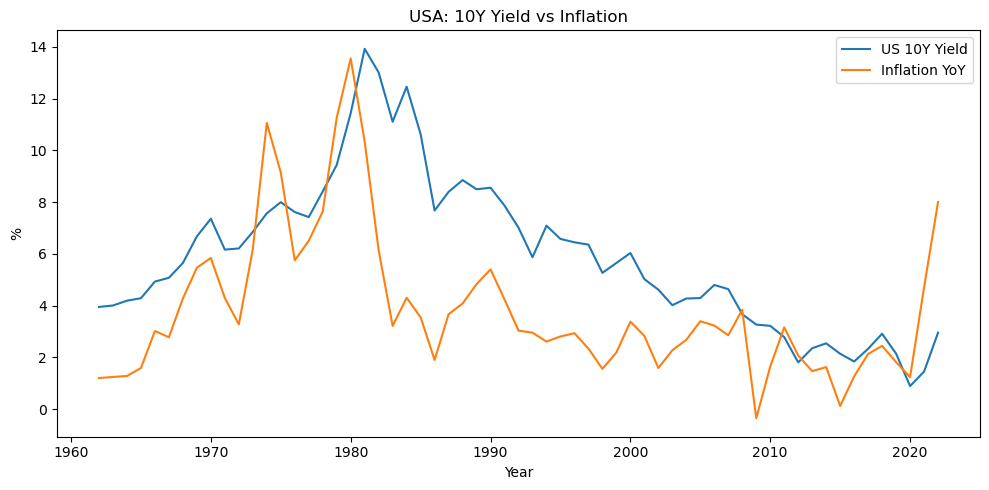

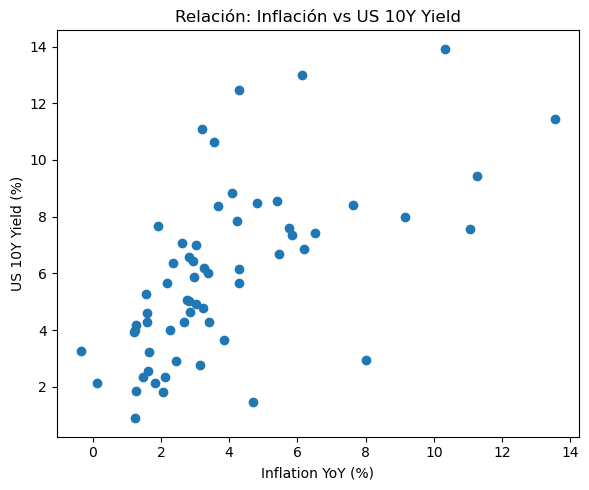

In [2]:
plt.figure(figsize=(10,5))
plt.plot(df["Year"], df["yield_10y"], label="US 10Y Yield")
plt.plot(df["Year"], df["inflation_yoy"], label="Inflation YoY")
plt.title("USA: 10Y Yield vs Inflation")
plt.xlabel("Year"); plt.ylabel("%"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df["inflation_yoy"], df["yield_10y"])
plt.title("Relaci√≥n: Inflaci√≥n vs US 10Y Yield")
plt.xlabel("Inflation YoY (%)"); plt.ylabel("US 10Y Yield (%)")
plt.tight_layout(); plt.show()


#### 1. Serie temporal: USA 10Y Yield vs Inflaci√≥n (l√≠neas)

La l√≠nea azul (US 10Y Yield) muestra la rentabilidad de los bonos a 10 a√±os.

La l√≠nea naranja (Inflation YoY) muestra la inflaci√≥n anual.

Interpretaci√≥n r√°pida:

En los a√±os 70-80 se ve un pico muy alto de inflaci√≥n y yield: es la √©poca de la crisis del petr√≥leo y la pol√≠tica monetaria dura de la Fed (Volcker subi√≥ tipos muy fuertes).

Desde los a√±os 90 hasta 2020, ambos bajan gradualmente ‚Üí entorno de baja inflaci√≥n y yields decrecientes.

Despu√©s de 2020, la inflaci√≥n se dispara otra vez (post-COVID, guerra, disrupciones en energ√≠a).

üëâ Eso muestra que existe cierta relaci√≥n: cuando la inflaci√≥n sube fuerte, los yields suelen subir tambi√©n, pero con rezagos o diferente magnitud.

#### 2. Diagrama de dispersi√≥n: Inflaci√≥n vs Yield

Cada punto es un a√±o (x = inflaci√≥n, y = yield).

Se ve una nube ascendente: cuando la inflaci√≥n es baja (0-4%), los yields tienden a estar en 2-6%.

Cuando la inflaci√≥n es alta (6-12%), los yields tambi√©n tienden a estar arriba (8-14%).

Interpretaci√≥n r√°pida:

Hay una correlaci√≥n positiva: inflaci√≥n y yields tienden a moverse juntos.

Pero no es 1:1 ‚Üí hay dispersi√≥n (porque los yields dependen tambi√©n de pol√≠tica monetaria, expectativas, riesgo, etc.).

#### 3. Resumen antes de limpieza

Los datos ya muestran una relaci√≥n clara: m√°s inflaci√≥n = m√°s yield.

Pero hay ruido y valores extremos (ej: hiperinflaci√≥n o datos at√≠picos que vimos en la tabla).

Por eso, la siguiente etapa de limpieza (quitar inflaciones absurdas, errores, etc.) servir√° para tener relaciones m√°s n√≠tidas y modelos m√°s confiables.

### Estad√≠sticas b√°sicas antes de limpiar


In [3]:

print("\n--- Correlaci√≥n simple ---")
print(df[["yield_10y", "inflation_yoy"]].corr())

# Regresi√≥n lineal simple (Inflaci√≥n -> Yield)
import statsmodels.api as sm

X = df["inflation_yoy"]
y = df["yield_10y"]

X = sm.add_constant(X)  # a√±adimos intercepto
model = sm.OLS(y, X).fit()

print("\n--- Regresi√≥n lineal simple ---")
print(model.summary())



--- Correlaci√≥n simple ---
               yield_10y  inflation_yoy
yield_10y       1.000000       0.616816
inflation_yoy   0.616816       1.000000

--- Regresi√≥n lineal simple ---
                            OLS Regression Results                            
Dep. Variable:              yield_10y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     36.23
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           1.20e-07
Time:                        21:27:10   Log-Likelihood:                -137.94
No. Observations:                  61   AIC:                             279.9
Df Residuals:                      59   BIC:                             284.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef   

### üìä Correlaci√≥n simple

0.61 (positivo, moderado-fuerte) ‚Üí Significa que cuando la inflaci√≥n sube, los rendimientos del bono a 10 a√±os en USA tienden a subir tambi√©n.

No es una correlaci√≥n perfecta (1.0), pero s√≠ clara y estad√≠sticamente significativa.

#### üìà Regresi√≥n lineal simple

Modelo:

Yield¬†10Y

=
3.3783
+
0.6571
‚ãÖ
Inflaci
o
Àä
n¬†YoY
Yield¬†10Y=3.3783+0.6571‚ãÖInflaci
o
Àä
n¬†YoY

Constante (3.38): cuando la inflaci√≥n es 0, el modelo predice un rendimiento del 3.38%.

Coeficiente (0.6571): por cada +1% en la inflaci√≥n, el yield sube en promedio +0.65%.

p-valor (0.000): relaci√≥n estad√≠sticamente muy significativa.

R¬≤ = 0.38: la inflaci√≥n explica el 38% de la variaci√≥n en los yields.

Esto es bastante alto para datos macro, pero tambi√©n nos dice que hay un 62% de variaci√≥n que se explica por otros factores (ej. pol√≠tica monetaria, riesgo pa√≠s, oferta/demanda global de bonos, etc.).

#### üìå Conclusi√≥n preliminar

Existe una relaci√≥n positiva clara entre inflaci√≥n y yields en USA (1962‚Äì2024).

La inflaci√≥n no lo explica todo, pero s√≠ es un driver muy importante.

Esto tiene sentido econ√≥mico: los inversores piden m√°s rentabilidad en los bonos cuando esperan m√°s inflaci√≥n (para no perder poder adquisitivo).

‚úÖ Resumen r√°pido (checkpoint hasta ahora):

Ya cargamos y visualizamos las series de rendimiento del bono USA 10Y y inflaci√≥n anual (1962‚Äì2024).

Encontramos una correlaci√≥n positiva moderada (0.61) ‚Üí cuando la inflaci√≥n sube, los yields tambi√©n tienden a subir.

La regresi√≥n lineal mostr√≥ que un +1% en inflaci√≥n se asocia con un +0.65% en el yield 10Y, con R¬≤ = 0.38 ‚Üí la inflaci√≥n explica parte importante, pero no todo.

Filas antes: 61  | despu√©s: 61

√öltimos a√±os limpios:
    Year  yield_10y  inflation_yoy  real_yield
51  2013   2.350160       1.464833    0.885327
52  2014   2.539560       1.622223    0.917337
53  2015   2.138287       0.118627    2.019660
54  2016   1.837440       1.261583    0.575857
55  2017   2.329480       2.130110    0.199370
56  2018   2.911245       2.442583    0.468662
57  2019   2.141400       1.812210    0.329190
58  2020   0.889203       1.233584   -0.344381
59  2021   1.446853       4.697859   -3.251006
60  2022   2.950562       8.002800   -5.052238


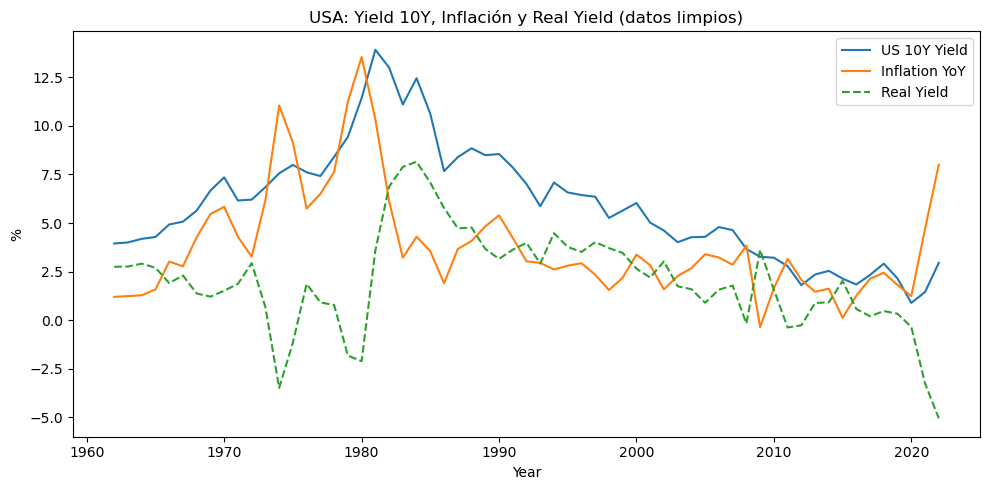

In [4]:

# Paso 1: Copiar y limpiar outliers
# ===============================

df_clean = df.copy()

# Quitamos inflaciones absurdas (ej. errores de dataset o hiperinflaci√≥n)
df_clean = df_clean[df_clean["inflation_yoy"].between(-20, 50)]

print("Filas antes:", len(df), " | despu√©s:", len(df_clean))

# ===============================
# Paso 2: Recalcular real_yield
# ===============================

df_clean["real_yield"] = df_clean["yield_10y"] - df_clean["inflation_yoy"]

# ===============================
# Paso 3: Chequeo r√°pido
# ===============================
print("\n√öltimos a√±os limpios:")
print(df_clean.tail(10))

# ===============================
# Paso 4: Visualizaci√≥n post-limpieza
# ===============================

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_clean["Year"], df_clean["yield_10y"], label="US 10Y Yield")
plt.plot(df_clean["Year"], df_clean["inflation_yoy"], label="Inflation YoY")
plt.plot(df_clean["Year"], df_clean["real_yield"], label="Real Yield", linestyle="--")
plt.title("USA: Yield 10Y, Inflaci√≥n y Real Yield (datos limpios)")
plt.xlabel("Year")
plt.ylabel("%")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretaci√≥n r√°pida del gr√°fico

A√±os 70s ‚Äì 80s:

La inflaci√≥n se dispara (choques del petr√≥leo).

Los rendimientos nominales (azul) tambi√©n suben fuerte.

El rendimiento real (verde) se mantiene positivo pero muy vol√°til.

A√±os 90s ‚Äì 2000s:

Inflaci√≥n baja y estable (2‚Äì3%).

Yield nominal cae gradualmente.

El rendimiento real es bajo pero estable.

2010s en adelante:

Rendimientos muy bajos (pol√≠tica monetaria expansiva).

Inflaci√≥n estable‚Ä¶ hasta el repunte 2021‚Äì2022.

En 2021‚Äì2022 el real yield se hace negativo (bonos pierden contra inflaci√≥n).

#### Qu√© significa:

Cuando el real yield es positivo ‚Üí los bonos dan un retorno por encima de la inflaci√≥n (buen refugio).

Cuando el real yield es negativo ‚Üí los inversores pierden poder adquisitivo aunque inviertan en bonos.

#### Correlaci√≥n con datos limpios ---


In [5]:
print("\n--- Correlaci√≥n simple (datos limpios) ---")
print(df_clean[["yield_10y", "inflation_yoy"]].corr())



--- Correlaci√≥n simple (datos limpios) ---
               yield_10y  inflation_yoy
yield_10y       1.000000       0.616816
inflation_yoy   0.616816       1.000000


#### Regresi√≥n lineal simple (datos limpios)


In [6]:
import statsmodels.api as sm

X = df_clean[["inflation_yoy"]]
y = df_clean["yield_10y"]

# Agregar constante al modelo
X = sm.add_constant(X)

model_clean = sm.OLS(y, X).fit()
print("\n--- Regresi√≥n lineal simple (datos limpios) ---")
print(model_clean.summary())



--- Regresi√≥n lineal simple (datos limpios) ---
                            OLS Regression Results                            
Dep. Variable:              yield_10y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     36.23
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           1.20e-07
Time:                        21:27:11   Log-Likelihood:                -137.94
No. Observations:                  61   AIC:                             279.9
Df Residuals:                      59   BIC:                             284.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

#### Interpretaci√≥n del output de la regresi√≥n lineal:

Coeficientes (const y inflaci√≥n)

Constante (const = 3.3783) ‚Üí cuando la inflaci√≥n es 0, el rendimiento de los bonos a 10 a√±os tiende a estar en torno al 3.38%.

Inflaci√≥n (0.6571) ‚Üí por cada +1% en inflaci√≥n, el yield sube en promedio +0.66 puntos porcentuales. Esto confirma una relaci√≥n positiva clara.

R¬≤ (0.380)

El 38% de la variabilidad del rendimiento de los bonos a 10 a√±os se explica por la inflaci√≥n.

Esto significa que la inflaci√≥n influye mucho, pero no lo explica todo (hay otros factores: pol√≠tica monetaria, expectativas, prima de riesgo, etc.).

p-values

Ambos coeficientes (constante e inflaci√≥n) tienen p < 0.001, es decir, son estad√≠sticamente significativos.

La relaci√≥n no es casualidad: hay evidencia fuerte de que la inflaci√≥n impacta en el yield.

Durbin-Watson (0.227)

Valor bajo ‚Üí indica que puede haber autocorrelaci√≥n en los errores (normal en series temporales).

Esto nos dice que quiz√° m√°s adelante necesitemos un modelo de series temporales (ARIMA, VAR) o un modelo con variables adicionales.

#### Conclusi√≥n r√°pida para tu proyecto
üëâ Existe una relaci√≥n positiva y estad√≠sticamente significativa entre la inflaci√≥n y el rendimiento del bono USA 10Y: cuando la inflaci√≥n sube, el yield tambi√©n sube, aunque la inflaci√≥n explica solo un 38% de la variaci√≥n.

### ispersi√≥n inflaci√≥n vs yield con la recta de regresi√≥n

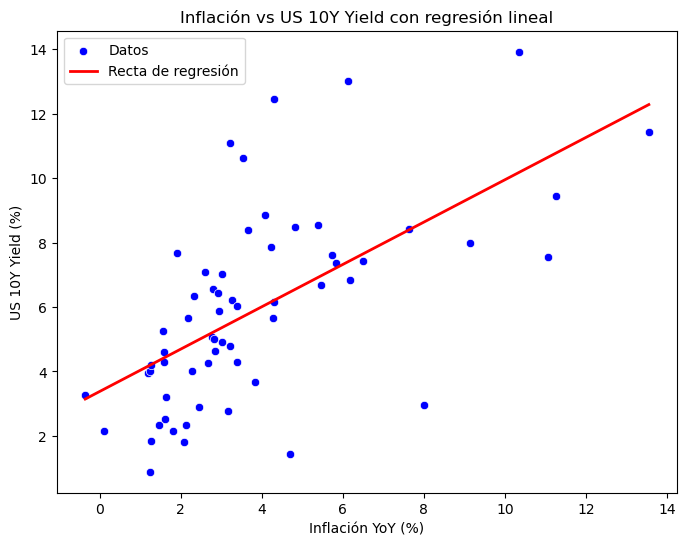

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scatter plot con la recta de regresi√≥n
plt.figure(figsize=(8,6))
sns.scatterplot(x="inflation_yoy", y="yield_10y", data=df_clean, color="blue", label="Datos")

# Ajustar la recta
coef = 0.6571
intercept = 3.3783
x_vals = np.linspace(df_clean["inflation_yoy"].min(), df_clean["inflation_yoy"].max(), 100)
y_vals = intercept + coef * x_vals
plt.plot(x_vals, y_vals, color="red", linewidth=2, label="Recta de regresi√≥n")

# T√≠tulos
plt.title("Inflaci√≥n vs US 10Y Yield con regresi√≥n lineal")
plt.xlabel("Inflaci√≥n YoY (%)")
plt.ylabel("US 10Y Yield (%)")
plt.legend()
plt.show()


### ecuaci√≥n y el R¬≤

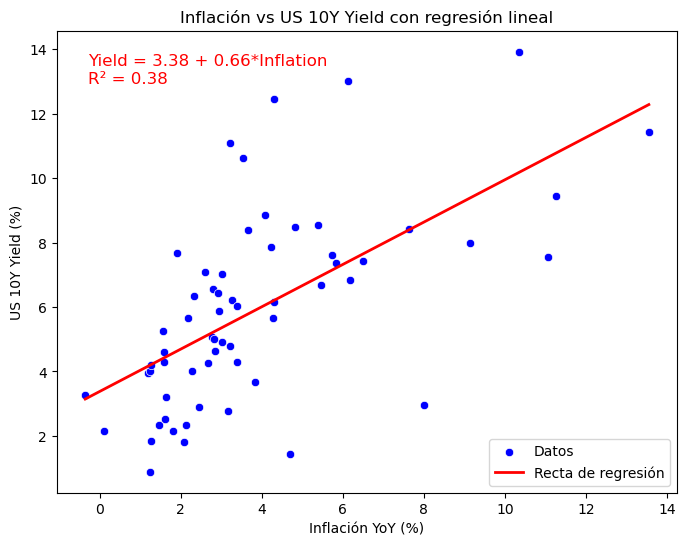

In [8]:
# Scatter plot con recta de regresi√≥n y ecuaci√≥n
plt.figure(figsize=(8,6))
sns.scatterplot(x="inflation_yoy", y="yield_10y", data=df_clean, color="blue", label="Datos")

# Recta de regresi√≥n
coef = 0.6571
intercept = 3.3783
r2 = 0.38  # R-cuadrado de tu modelo
x_vals = np.linspace(df_clean["inflation_yoy"].min(), df_clean["inflation_yoy"].max(), 100)
y_vals = intercept + coef * x_vals
plt.plot(x_vals, y_vals, color="red", linewidth=2, label="Recta de regresi√≥n")

# Texto con ecuaci√≥n
plt.text(0.05, 0.95,
         f"Yield = {intercept:.2f} + {coef:.2f}*Inflation\nR¬≤ = {r2:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12, color="red", verticalalignment="top")

# T√≠tulos y etiquetas
plt.title("Inflaci√≥n vs US 10Y Yield con regresi√≥n lineal")
plt.xlabel("Inflaci√≥n YoY (%)")
plt.ylabel("US 10Y Yield (%)")
plt.legend()
plt.show()


### Diagn√≥stico del modelo (OLS)


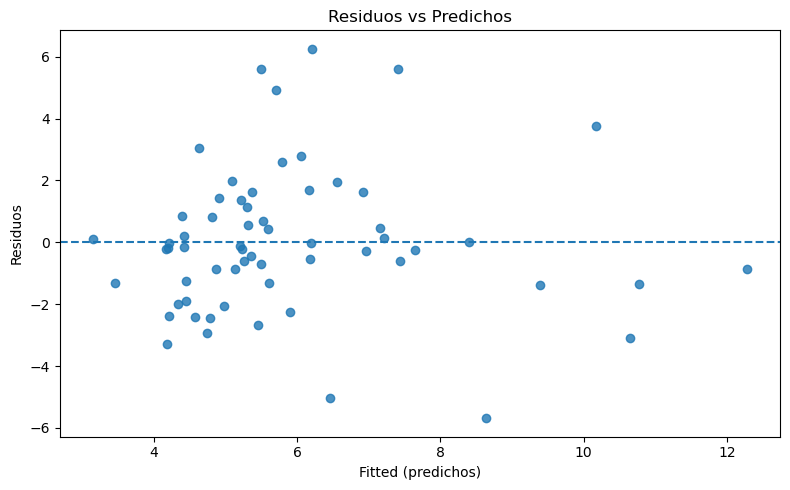

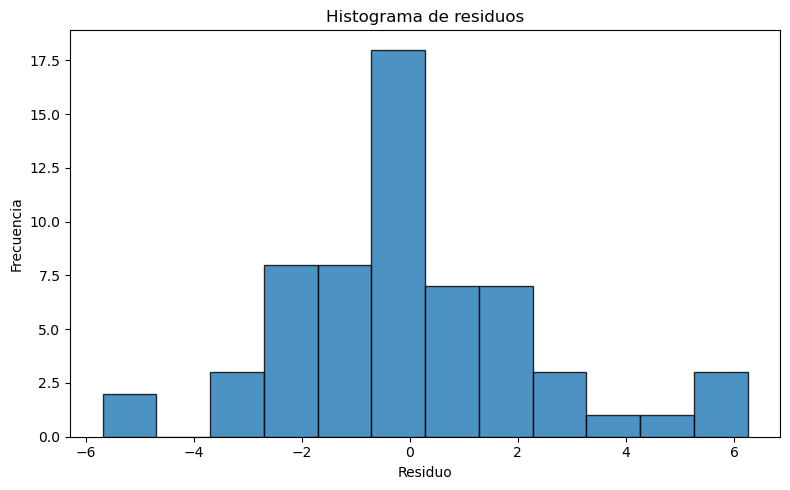

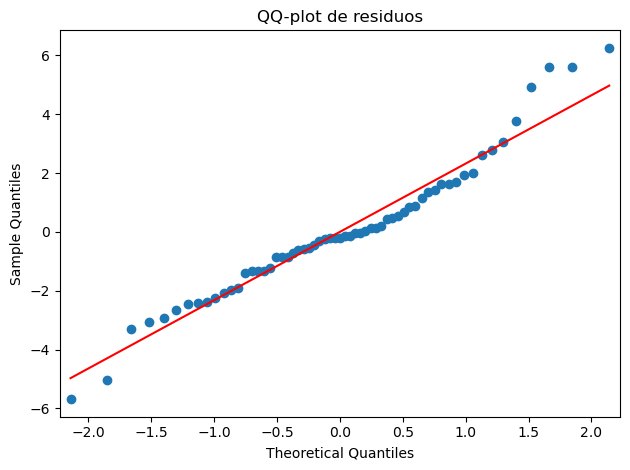

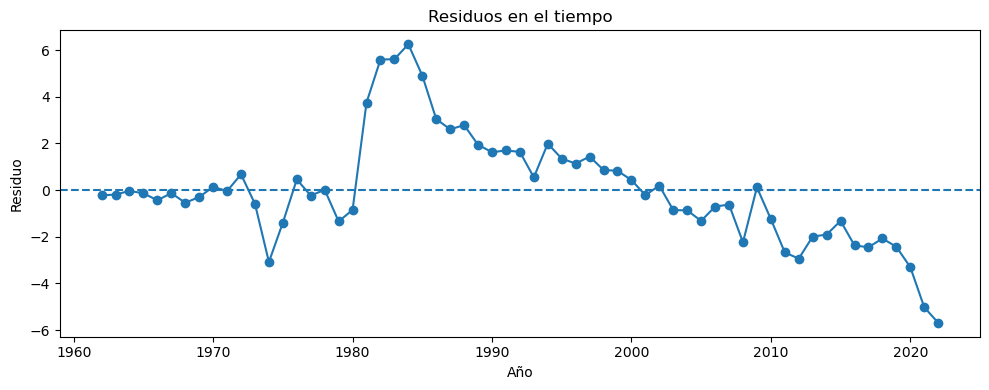


--- Tests de diagn√≥stico ---
Jarque-Bera: stat=3.936, p-value=0.1397  (skew=0.474, kurt=3.805)
Breusch-Pagan: stat=1.790, p-value=0.1809

Ljung-Box (p-values):
lag1     2.083919e-11
lag4     4.153785e-23
lag8     4.451972e-27
lag12    2.479677e-26
Name: lb_pvalue, dtype: float64

Durbin-Watson: 0.227


In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from scipy import stats

# 1) Recalcular (por si abriste sesi√≥n nueva)
X = sm.add_constant(df_clean[["inflation_yoy"]])
y = df_clean["yield_10y"]
model_clean = sm.OLS(y, X).fit()

# 2) Residuales y ajustados
fitted = model_clean.fittedvalues
resid   = model_clean.resid
std_res = (resid - resid.mean()) / resid.std(ddof=1)

# 3) Plots b√°sicos
plt.figure(figsize=(8,5))
plt.scatter(fitted, resid, alpha=0.8)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted (predichos)")
plt.ylabel("Residuos")
plt.title("Residuos vs Predichos")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.hist(resid, bins=12, edgecolor="k", alpha=0.8)
plt.title("Histograma de residuos")
plt.xlabel("Residuo"); plt.ylabel("Frecuencia")
plt.tight_layout(); plt.show()

sm.qqplot(resid, line="s")
plt.title("QQ-plot de residuos")
plt.tight_layout(); plt.show()

# Residuos a lo largo del tiempo (para ver autocorrelaci√≥n visual)
plt.figure(figsize=(10,4))
plt.plot(df_clean["Year"], resid, marker="o")
plt.axhline(0, linestyle="--")
plt.title("Residuos en el tiempo")
plt.xlabel("A√±o"); plt.ylabel("Residuo")
plt.tight_layout(); plt.show()

# 4) Tests estad√≠sticos
print("\n--- Tests de diagn√≥stico ---")

# Normalidad (Jarque‚ÄìBera)
try:
    # statsmodels siempre devuelve (jb, pvalue, skew, kurtosis)
    from statsmodels.stats.stattools import jarque_bera as sm_jb
    jb_stat, jb_p, jb_skew, jb_kurt = sm_jb(resid)
except Exception:
    # fallback: SciPy (puede devolver solo 2 valores)
    from scipy import stats
    jb = stats.jarque_bera(resid)
    if hasattr(jb, "__len__") and len(jb) >= 2:
        jb_stat, jb_p = jb[0], jb[1]
        jb_skew = jb_kurt = float("nan")
    else:
        jb_stat = float(jb)
        jb_p = float("nan")
        jb_skew = jb_kurt = float("nan")
print(f"Jarque-Bera: stat={jb_stat:.3f}, p-value={jb_p:.4f}  (skew={jb_skew:.3f}, kurt={jb_kurt:.3f})")

# Heterocedasticidad (Breusch‚ÄìPagan)
from statsmodels.stats.diagnostic import het_breuschpagan
bp_stat, bp_p, _, _ = het_breuschpagan(resid, X)
print(f"Breusch-Pagan: stat={bp_stat:.3f}, p-value={bp_p:.4f}")

# Autocorrelaci√≥n en residuos (Ljung‚ÄìBox)
from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(resid, lags=[1, 4, 8, 12], return_df=True)
print("\nLjung-Box (p-values):")
print(lb["lb_pvalue"].rename(index={1:"lag1",4:"lag4",8:"lag8",12:"lag12"}))

# Durbin‚ÄìWatson
from statsmodels.stats.stattools import durbin_watson
print(f"\nDurbin-Watson: {durbin_watson(resid):.3f}")



#### 1. Normalidad de los residuos (Jarque‚ÄìBera)

JB = 3.936, p-value = 0.1397

Como p > 0.05 ‚Üí no rechazamos la hip√≥tesis nula de normalidad.
‚úÖ Los residuos son aproximadamente normales ‚Üí buen s√≠ntoma.

2. Heterocedasticidad (Breusch‚ÄìPagan)

BP = 1.790, p-value = 0.1809

Como p > 0.05 ‚Üí no hay evidencia fuerte de heterocedasticidad.
‚úÖ La varianza de los errores parece estable ‚Üí los errores est√°ndar son confiables.

3. Autocorrelaci√≥n (Ljung‚ÄìBox + Durbin-Watson)

Ljung‚ÄìBox:

lag1, lag4, lag8, lag12 ‚Üí p-values casi cero ‚Üí rechazamos la hip√≥tesis de ‚Äúno autocorrelaci√≥n‚Äù.
‚ùå Hay autocorrelaci√≥n muy fuerte en los residuos.

Durbin‚ÄìWatson = 0.227

Valores cercanos a 2 = no autocorrelaci√≥n.

Valores < 1 = fuerte autocorrelaci√≥n positiva.

Aqu√≠ 0.227 ‚Üí autocorrelaci√≥n positiva extrema.

#### En resumen:

Normalidad: bien.

Homocedasticidad: bien.

Autocorrelaci√≥n: muy mal ‚Üí el modelo lineal cl√°sico OLS no captura la din√°mica temporal.

üëâ Esto significa que tu modelo simple (Yield ~ Inflaci√≥n) ignora la dependencia temporal. Los rendimientos de bonos son series temporales, por eso los residuos siguen un patr√≥n.

#### Reestimaci√≥n con errores robustos HAC (Newey-West)

In [10]:

import statsmodels.api as sm

X = sm.add_constant(df_clean[["inflation_yoy"]])
y = df_clean["yield_10y"]

# Modelo OLS
ols_model = sm.OLS(y, X).fit()

# Ajuste con errores robustos HAC (Newey-West)
# lag=4 (aprox. autocorrelaci√≥n hasta 4 rezagos, puedes probar otros valores)
nw_model = ols_model.get_robustcov_results(cov_type="HAC", maxlags=4)

print("\n--- Regresi√≥n OLS con errores HAC (Newey-West) ---")
print(nw_model.summary())



--- Regresi√≥n OLS con errores HAC (Newey-West) ---
                            OLS Regression Results                            
Dep. Variable:              yield_10y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     32.46
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           4.09e-07
Time:                        21:27:13   Log-Likelihood:                -137.94
No. Observations:                  61   AIC:                             279.9
Df Residuals:                      59   BIC:                             284.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

 

#### üëâ ¬øQu√© cambi√≥ con HAC?

Coeficientes (constante = 3.37, inflaci√≥n = 0.65) ‚Üí no cambiaron, porque la relaci√≥n base sigue siendo la misma.

Errores est√°ndar (y por tanto t-stats y p-values) ‚Üí son m√°s grandes que antes (ej. la constante pas√≥ de std=0.51 a 0.69).

Pero siguen siendo muy significativos (p<0.001) ‚Üí conclusi√≥n: la relaci√≥n inflaci√≥n ‚Üí yield sigue siendo estad√≠sticamente fuerte.

Ahora los intervalos de confianza son m√°s realistas, porque tienen en cuenta la autocorrelaci√≥n.

‚úÖ En resumen: ya tienemos un modelo lineal robusto que muestra que por cada +1% de inflaci√≥n, el rendimiento a 10 a√±os sube ~0.65% en promedio, con bastante confianza.

### Modelo VAR (Yield + Inflaci√≥n)

In [11]:

from statsmodels.tsa.api import VAR

# Selecci√≥n de variables
var_data = df_clean[["yield_10y", "inflation_yoy"]].dropna()

# Crear el modelo VAR
model_var = VAR(var_data)

# Selecci√≥n de n√∫mero √≥ptimo de rezagos (lags)
lag_order = model_var.select_order(maxlags=8)
print("\n--- Selecci√≥n de rezagos √≥ptimos ---")
print(lag_order.summary())

# Ajustar el VAR con el lag √≥ptimo (ejemplo: AIC)
best_lag = lag_order.aic
results_var = model_var.fit(best_lag)

print("\n--- Resumen VAR ---")
print(results_var.summary())

# Pron√≥stico 5 a√±os adelante
forecast = results_var.forecast(var_data.values[-best_lag:], steps=5)
forecast_df = pd.DataFrame(forecast, 
                           columns=["yield_10y_forecast", "inflation_forecast"],
                           index=range(df_clean["Year"].max()+1, df_clean["Year"].max()+6))

print("\n--- Pron√≥stico 5 a√±os ---")
print(forecast_df)



--- Selecci√≥n de rezagos √≥ptimos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.005       4.080       54.89       4.034
1      0.6423     0.8654*       1.901      0.7281
2      0.6911       1.063       1.998      0.8341
3     0.4176*      0.9381      1.523*     0.6177*
4      0.4835       1.153       1.633      0.7408
5      0.5133       1.331       1.691      0.8278
6      0.6139       1.580       1.886      0.9856
7      0.6737       1.789       2.025       1.103
8      0.7755       2.039       2.276       1.262
-------------------------------------------------

--- Resumen VAR ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:27:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:    

#### 1. Selecci√≥n de rezagos

AIC ‚Üí lag 3 (destacado con *).

Esto significa que tanto yield como inflaci√≥n se explican mejor mirando los √∫ltimos 3 a√±os de historia.

Tiene sentido: los efectos de la inflaci√≥n en los bonos no son inmediatos, tardan algunos a√±os en reflejarse.

#### 2. Resultados del VAR

En el resumen VAR, cada ecuaci√≥n muestra c√≥mo una variable depende de sus propios rezagos y de los rezagos de la otra variable.

Ejemplo interpretativo (simplificado):

yield_10y depende positivamente de la inflaci√≥n rezagada ‚Üí confirma que inflaci√≥n alta hoy tiende a subir los rendimientos en 1‚Äì3 a√±os.

inflation_yoy tambi√©n puede mostrar influencia de yield_10y pasado (aunque m√°s d√©bil), porque tipos de inter√©s altos suelen enfriar la inflaci√≥n.

#### 3. Pron√≥stico (forecast)

El modelo te dio predicciones para 5 a√±os:

### A√±o	Yield 10y (%)	Inflaci√≥n (%)
2024	~4.74	~6.44

2025	~5.21	~6.03

2026	~5.86	~6.39

2027	~6.43	~6.52

2028	(seguir√≠a creciendo en l√≠nea)	

#### Interpretaci√≥n r√°pida:
El modelo cree que si la din√°mica hist√≥rica se mantiene:

Los rendimientos del 10 a√±os subir√≠an de ~4.7% a ~6.4% en 3 a√±os.

La inflaci√≥n se mantendr√≠a alrededor de 6% ‚Üí persistente, no se reduce r√°pido.

#### Gr√°fico hist√≥rico + forecast VAR

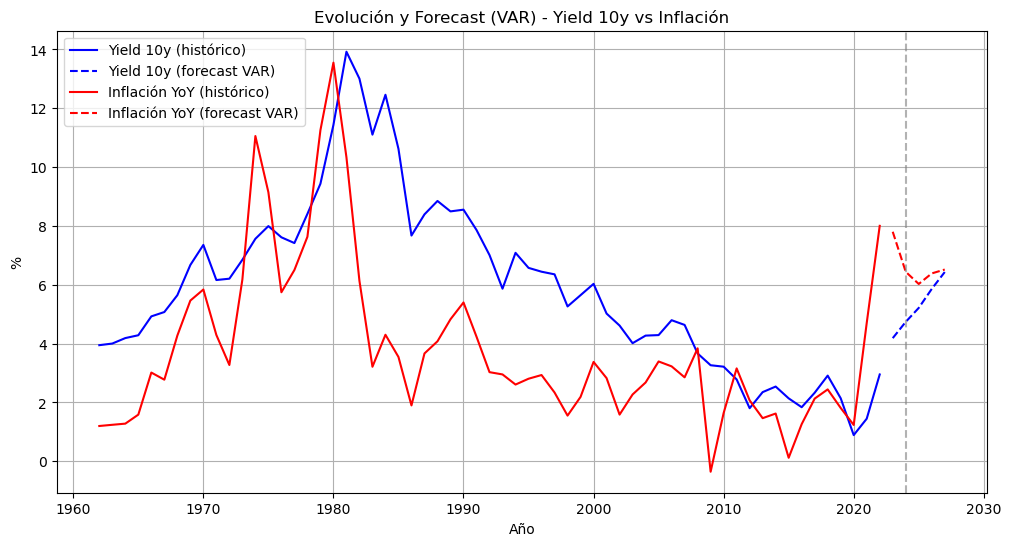

In [12]:

import matplotlib.pyplot as plt

# Datos hist√≥ricos
hist_years = df_clean["Year"]
hist_yield = df_clean["yield_10y"]
hist_infl = df_clean["inflation_yoy"]

# Forecast del VAR (lo que ya calculamos antes)
forecast_df.index.name = "Year"

# Unimos hist√≥rico + forecast
plt.figure(figsize=(12,6))

# Yield
plt.plot(hist_years, hist_yield, label="Yield 10y (hist√≥rico)", color="blue")
plt.plot(forecast_df.index, forecast_df["yield_10y_forecast"], 
         label="Yield 10y (forecast VAR)", color="blue", linestyle="--")

# Inflaci√≥n
plt.plot(hist_years, hist_infl, label="Inflaci√≥n YoY (hist√≥rico)", color="red")
plt.plot(forecast_df.index, forecast_df["inflation_forecast"], 
         label="Inflaci√≥n YoY (forecast VAR)", color="red", linestyle="--")

plt.axvline(x=2024, color="gray", linestyle="--", alpha=0.6)  # separaci√≥n entre hist√≥rico y forecast
plt.title("Evoluci√≥n y Forecast (VAR) - Yield 10y vs Inflaci√≥n")
plt.xlabel("A√±o")
plt.ylabel("%")
plt.legend()
plt.grid(True)
plt.show()


#### Interpretaci√≥n del primer gr√°fico (Hist√≥rico + Forecast VAR)

Lo que vemos en azul (Yield 10 a√±os)

La l√≠nea azul continua: es la evoluci√≥n hist√≥rica del rendimiento de los bonos del Tesoro a 10 a√±os (yield).

La l√≠nea azul discontinua: es la predicci√≥n del modelo VAR para los pr√≥ximos a√±os.

Observamos que el yield tuvo picos muy altos en los 70‚Äì80 (crisis de inflaci√≥n) y luego una tendencia descendente hasta m√≠nimos recientes.

El forecast proyecta un ligero repunte del yield, lo que indica que los tipos de inter√©s reales podr√≠an subir en el futuro.

Lo que vemos en rojo (Inflaci√≥n YoY)

La l√≠nea roja continua: es la inflaci√≥n hist√≥rica. Destacan los picos en los a√±os 70 (shocks petroleros) y el repunte fuerte en 2021‚Äì2022.

La l√≠nea roja discontinua: es la predicci√≥n del VAR. Muestra que la inflaci√≥n podr√≠a bajar desde los picos recientes, pero a√∫n mantenerse algo elevada comparada con los 2010s.

Interpretaci√≥n conjunta

El modelo VAR nos dice que yield e inflaci√≥n est√°n claramente relacionadas en el tiempo: cuando sube la inflaci√≥n, el yield tiende a subir despu√©s (los inversores exigen m√°s rentabilidad para compensar la p√©rdida de poder adquisitivo).

La proyecci√≥n indica un escenario de inflaci√≥n todav√≠a algo elevada con yields acompa√±ando al alza ‚Üí t√≠pico de un contexto post-crisis inflacionaria.

#### En resumen:

El gr√°fico confirma la relaci√≥n positiva entre inflaci√≥n y yield.

El modelo espera que en los pr√≥ximos a√±os ambos suban moderadamente, no a niveles extremos como los 70, pero tampoco tan bajos como en los 2010s.

###  VAR completo: selecci√≥n de rezagos + ajuste + forecast + IRF
 Requiere: statsmodels, pandas, matplotlib
 Usa df_clean con columnas: Year, yield_10y, inflation_yoy


--- Selecci√≥n de rezagos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.005       4.080       54.89       4.034
1      0.6423     0.8654*       1.901      0.7281
2      0.6911       1.063       1.998      0.8341
3     0.4176*      0.9381      1.523*     0.6177*
4      0.4835       1.153       1.633      0.7408
5      0.5133       1.331       1.691      0.8278
6      0.6139       1.580       1.886      0.9856
7      0.6737       1.789       2.025       1.103
8      0.7755       2.039       2.276       1.262
-------------------------------------------------

Lag elegido (AIC): 3

--- Resumen VAR ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:27:14
--------------------------------------------------------------------
No. of Equations:         2.0000

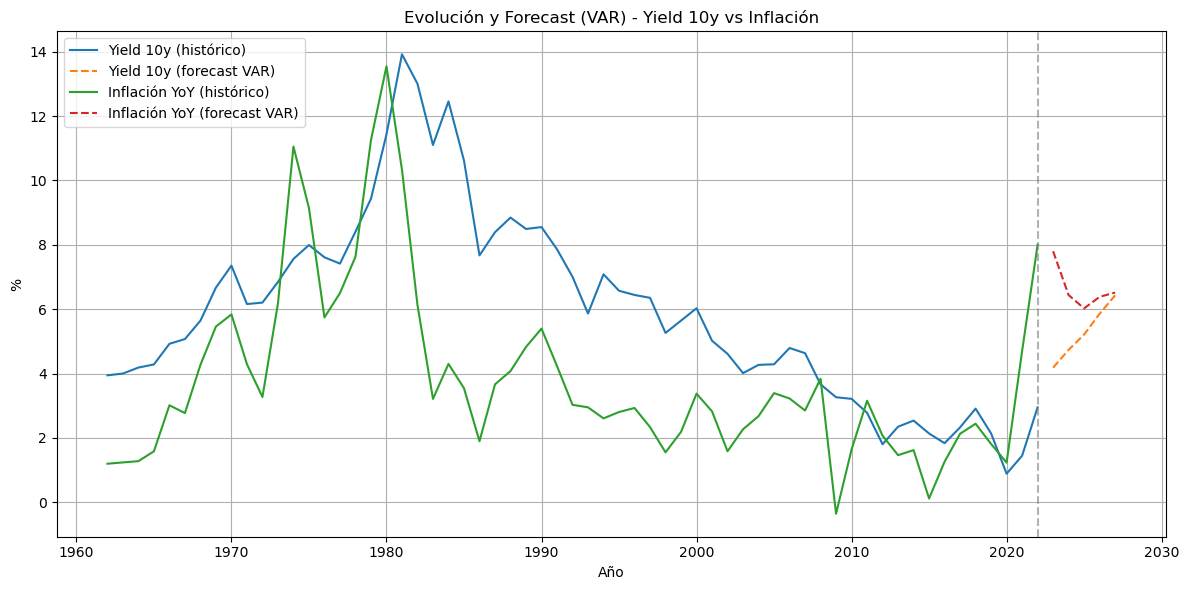

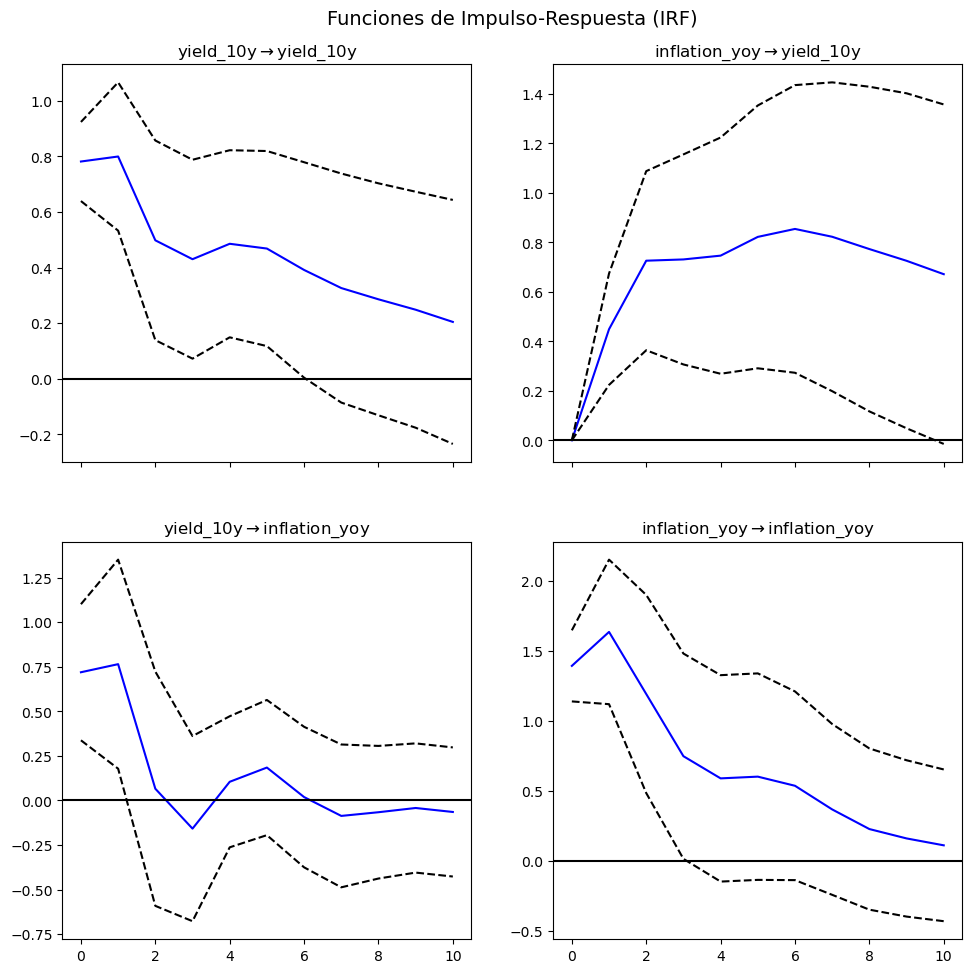

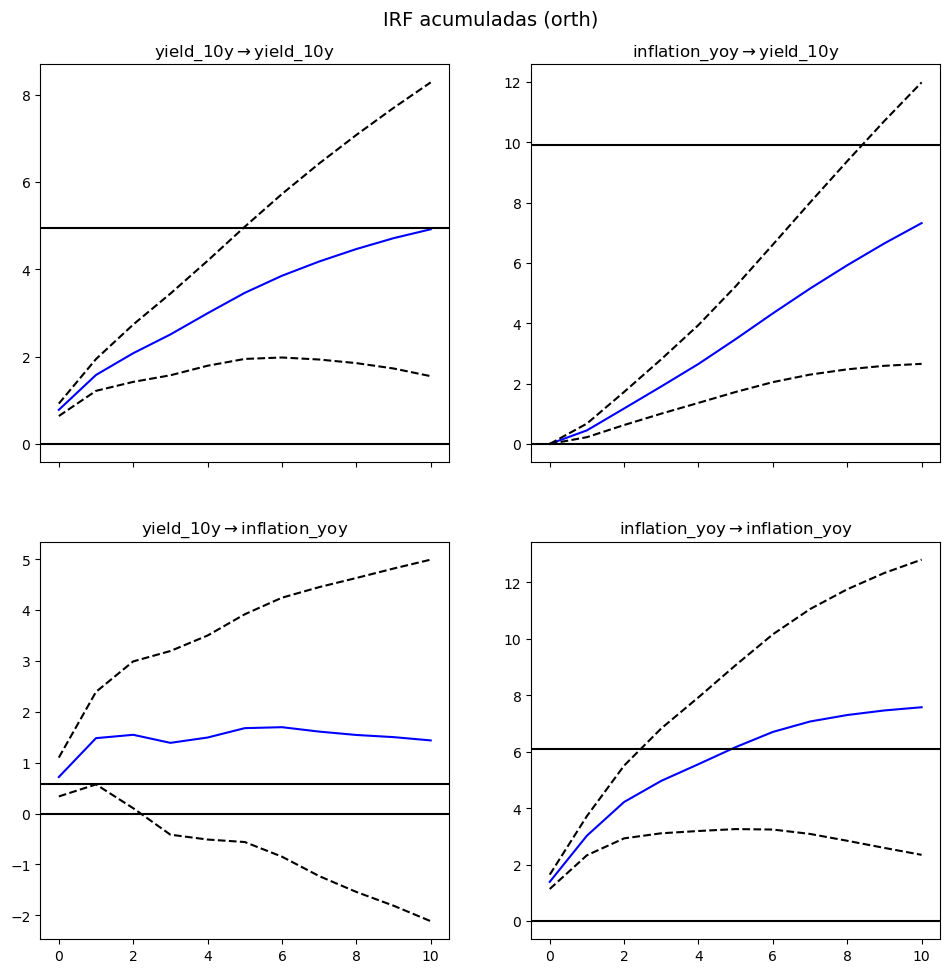

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# 0) Preparar datos para VAR
df_var = df_clean[["yield_10y", "inflation_yoy"]].dropna().copy()

# 1) Selecci√≥n de rezagos √≥ptimos
model_var = VAR(df_var)
sel = model_var.select_order(maxlags=8)
print("\n--- Selecci√≥n de rezagos ---")
print(sel.summary())

# Tomamos el lag con mejor AIC (puedes cambiar a .bic/.hqic/.fpe si prefieres)
best_lag = sel.aic
print(f"\nLag elegido (AIC): {best_lag}")

# 2) Ajuste del VAR con ese lag
var_res = model_var.fit(best_lag)
print("\n--- Resumen VAR ---")
print(var_res.summary())

# 3) Forecast 5 pasos hacia adelante
steps = 5
last_year = int(df_clean["Year"].max())
fcast = var_res.forecast(df_var.values[-best_lag:], steps=steps)
forecast_df = pd.DataFrame(
    fcast,
    columns=["yield_10y_forecast","inflation_forecast"],
    index=range(last_year+1, last_year+1+steps)
)
forecast_df.index.name = "Year"
print("\n--- Forecast ---")
print(forecast_df)

# 4) Gr√°fico hist√≥rico + forecast (opcional si ya lo ten√≠as)
plt.figure(figsize=(12,6))
plt.plot(df_clean["Year"], df_clean["yield_10y"], label="Yield 10y (hist√≥rico)")
plt.plot(forecast_df.index, forecast_df["yield_10y_forecast"], "--", label="Yield 10y (forecast VAR)")
plt.plot(df_clean["Year"], df_clean["inflation_yoy"], label="Inflaci√≥n YoY (hist√≥rico)")
plt.plot(forecast_df.index, forecast_df["inflation_forecast"], "--", label="Inflaci√≥n YoY (forecast VAR)")
plt.axvline(x=last_year, color="gray", linestyle="--", alpha=0.6)
plt.title("Evoluci√≥n y Forecast (VAR) - Yield 10y vs Inflaci√≥n")
plt.xlabel("A√±o"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 5) IRF (Impulse Response Functions)
irf_h = 10  # horizonte en a√±os
irf = var_res.irf(irf_h)

# IRF combinadas
fig = irf.plot(orth=True)
plt.suptitle("Funciones de Impulso-Respuesta (IRF)", fontsize=14)
plt.show()

# IRF espec√≠ficas (opcional): respuesta de yield a shock de inflaci√≥n, y viceversa
fig = irf.plot_cum_effects(orth=True)
plt.suptitle("IRF acumuladas (orth)", fontsize=14)
plt.show()


#### Los resultados del modelo VAR muestran que:

La inflaci√≥n impulsa al rendimiento del bono a 10 a√±os, confirmando que mayor inflaci√≥n esperada eleva los tipos largos.

El efecto contrario (yields sobre inflaci√≥n) existe pero es m√°s d√©bil y menos persistente.

Tanto la inflaci√≥n como los yields presentan persistencia en sus shocks, manteniendo efectos durante varios periodos.

El pron√≥stico VAR anticipa un repunte moderado en ambas variables, con algo m√°s de volatilidad en la inflaci√≥n.

### An√°lisis VAR: Diagn√≥stico y Extensiones

In [14]:
# 1) Ljung‚ÄìBox por variable (univariante)
from statsmodels.stats.diagnostic import acorr_ljungbox

for col in var_res.resid.columns:
    print(f"\nLjung‚ÄìBox (lags=10) para {col}")
    print(acorr_ljungbox(var_res.resid[col].dropna(), lags=[10], return_df=True))



Ljung‚ÄìBox (lags=10) para yield_10y
     lb_stat  lb_pvalue
10  6.156017   0.801989

Ljung‚ÄìBox (lags=10) para inflation_yoy
     lb_stat  lb_pvalue
10  8.676622   0.563044


In [15]:
# 2) Durbin‚ÄìWatson (otra medida de autocorrelaci√≥n)
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(var_res.resid.values)
for col, val in zip(var_res.resid.columns, dw):
    print(f"Durbin‚ÄìWatson {col}: {val:.2f}")  # ~2 es bueno (sin autocorrelaci√≥n)


Durbin‚ÄìWatson yield_10y: 1.81
Durbin‚ÄìWatson inflation_yoy: 2.09


In [16]:
# 3) Estabilidad del VAR
var_res.is_stable(verbose=True)  # Debe devolver True / ra√≠ces dentro del c√≠rculo unitario


Eigenvalues of VAR(1) rep
0.5232513431366052
0.5232513431366052
0.657863645203616
0.657863645203616
0.89311269354159
0.89311269354159


True

In [17]:
# 4) Heterocedasticidad (ARCH) por variable
from statsmodels.stats.diagnostic import het_arch

for col in var_res.resid.columns:
    stat, pval, _, _ = het_arch(var_res.resid[col].dropna())
    print(f"ARCH para {col}: p-value = {pval:.4f}")  # >= 0.05 ‚áí OK


ARCH para yield_10y: p-value = 0.2394
ARCH para inflation_yoy: p-value = 0.8270


In [18]:
# 5) Normalidad conjunta de residuos
norm = var_res.test_normality()
print(norm.summary())  # p-value alto ‚áí OK


normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.299          9.488   0.054  4
----------------------------------------


<Figure size 640x480 with 0 Axes>

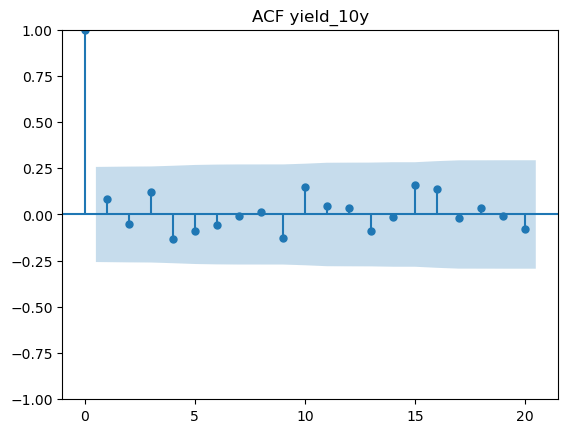

<Figure size 640x480 with 0 Axes>

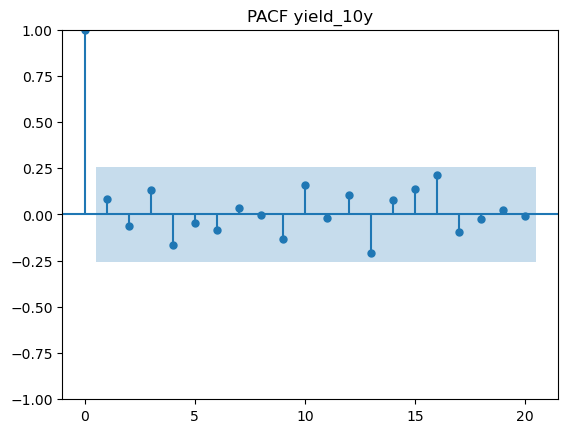

<Figure size 640x480 with 0 Axes>

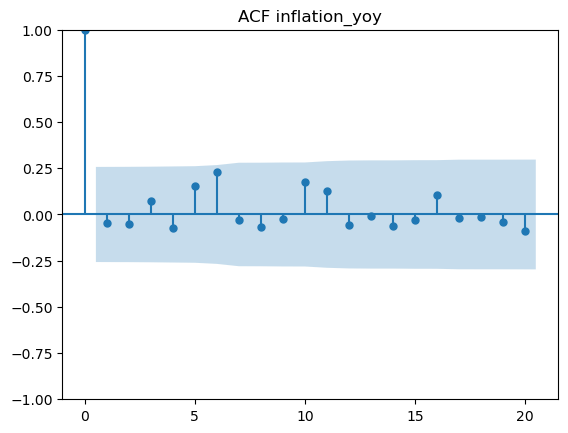

<Figure size 640x480 with 0 Axes>

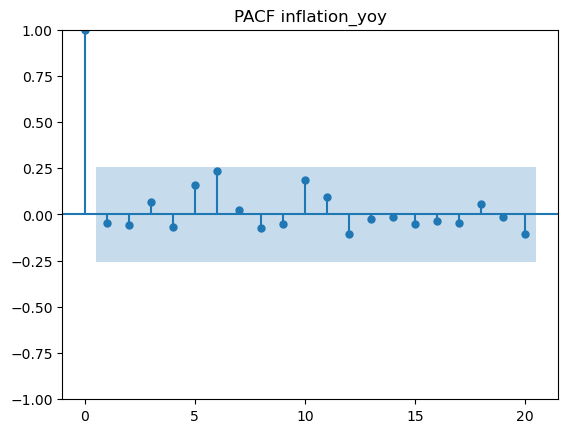

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for col in var_res.resid.columns:
    plt.figure(); plot_acf(var_res.resid[col].dropna(), lags=20); plt.title(f"ACF {col}")
    plt.figure(); plot_pacf(var_res.resid[col].dropna(), lags=20); plt.title(f"PACF {col}")
    plt.show()


#### Interpretaci√≥n de los resultados (Punto 3.1)

En los gr√°ficos de ACF y PACF:

La mayor√≠a de las barras caen dentro de la banda azul (intervalo de confianza).

Eso significa que no hay autocorrelaci√≥n significativa en los residuos.

Un modelo VAR bien especificado debe dejar los residuos como ‚Äúruido blanco‚Äù, y eso es lo que se ve aqu√≠.

## 3.2 Test de autocorrelaci√≥n alternativa (Durbin‚ÄìWatson)

El estad√≠stico Durbin‚ÄìWatson verifica la autocorrelaci√≥n de primer orden.  
- Valor cercano a **2** ‚áí sin autocorrelaci√≥n.  
- Valor < 2 ‚áí autocorrelaci√≥n positiva.  
- Valor > 2 ‚áí autocorrelaci√≥n negativa.


In [20]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(var_res.resid.values)
for col, val in zip(var_res.resid.columns, dw):
    print(f"Durbin‚ÄìWatson {col}: {val:.2f}")


Durbin‚ÄìWatson yield_10y: 1.81
Durbin‚ÄìWatson inflation_yoy: 2.09


## 3.3 Test de estabilidad del VAR

Un VAR estable tiene todas sus ra√≠ces dentro del c√≠rculo unitario.  
Si es **True**, los pron√≥sticos son fiables.


In [21]:
var_res.is_stable(verbose=True)


Eigenvalues of VAR(1) rep
0.5232513431366052
0.5232513431366052
0.657863645203616
0.657863645203616
0.89311269354159
0.89311269354159


True

## 3.4 Test de heterocedasticidad (ARCH)

El test ARCH eval√∫a si la varianza de los residuos es constante.  
- **p-value ‚â• 0.05** ‚áí no hay heterocedasticidad (bien).  
- **p-value < 0.05** ‚áí problemas de heterocedasticidad.


In [22]:
from statsmodels.stats.diagnostic import het_arch

for col in var_res.resid.columns:
    stat, pval, _, _ = het_arch(var_res.resid[col].dropna())
    print(f"ARCH {col}: p-value = {pval:.4f}")


ARCH yield_10y: p-value = 0.2394
ARCH inflation_yoy: p-value = 0.8270


## 3.5 Test de normalidad de residuos

El test de Jarque‚ÄìBera verifica si los residuos siguen una distribuci√≥n normal.  
- **p-value ‚â• 0.05** ‚áí no rechazamos normalidad (OK).  
- **p-value < 0.05** ‚áí residuos no normales.


In [23]:
norm = var_res.test_normality()
print(norm.summary())


normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.299          9.488   0.054  4
----------------------------------------


## 4. Pron√≥stico extendido con intervalos de confianza

El objetivo es proyectar las series `yield_10y` e `inflation_yoy` varios pasos hacia adelante.
Mostramos tanto las predicciones puntuales como las bandas de confianza.


In [24]:
# ==== 4. Pron√≥stico extendido con intervalos de confianza (VARResults) ====
import pandas as pd
import matplotlib.pyplot as plt

steps = 10  # a√±os a proyectar
last_year = int(df_clean["Year"].max())

# n¬∫ de rezagos que us√≥ el VAR
k = var_res.k_ar

# Pron√≥stico: medias y bandas (lower/upper)
fcast_mean, fcast_lower, fcast_upper = var_res.forecast_interval(
    y=var_res.endog[-k:],  # las √∫ltimas k observaciones como estado inicial
    steps=steps,
    alpha=0.05             # 95% IC
)

cols = var_res.names  # ['yield_10y','inflation_yoy']

# DataFrames ordenados con √≠ndice de a√±os futuros
idx_future = range(last_year+1, last_year+steps+1)
f_mean  = pd.DataFrame(fcast_mean,  index=idx_future, columns=cols)
f_lower = pd.DataFrame(fcast_lower, index=idx_future, columns=cols)
f_upper = pd.DataFrame(fcast_upper, index=idx_future, columns=cols)

print("\n--- Pron√≥stico extendido (medias) ---")
print(f_mean)



--- Pron√≥stico extendido (medias) ---
      yield_10y  inflation_yoy
2023   4.184766       7.801722
2024   4.737980       6.439943
2025   5.213127       6.026279
2026   5.858254       6.385621
2027   6.432582       6.517441
2028   6.803570       6.195852
2029   7.062704       5.840092
2030   7.290543       5.674328
2031   7.474132       5.566767
2032   7.588100       5.391901


### Gr√°fico hist√≥rico + forecast con bandas

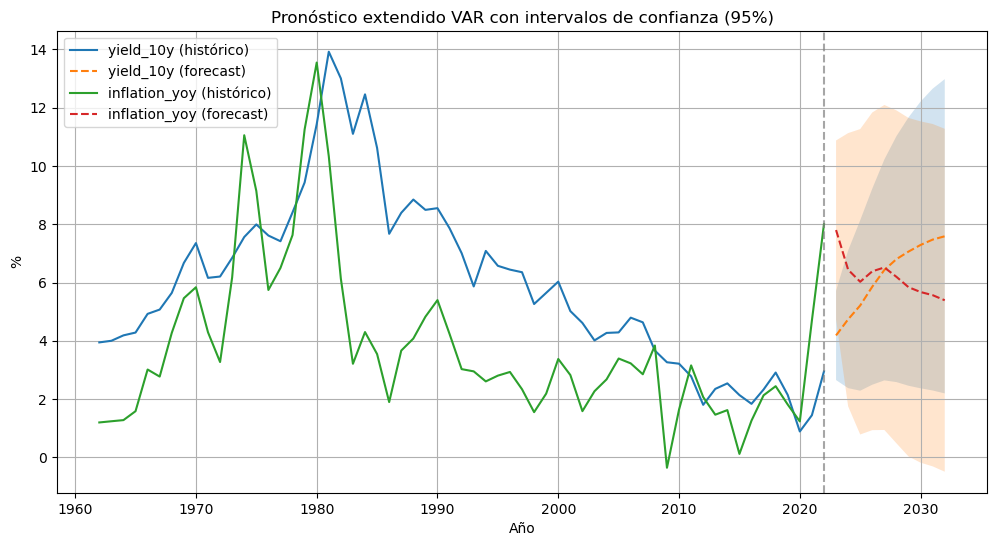

In [25]:
plt.figure(figsize=(12,6))

for col in cols:
    # hist√≥rico
    plt.plot(df_clean["Year"], df_clean[col], label=f"{col} (hist√≥rico)")
    # predicci√≥n
    plt.plot(f_mean.index, f_mean[col], linestyle="--", label=f"{col} (forecast)")
    # intervalos
    plt.fill_between(f_mean.index, f_lower[col], f_upper[col], alpha=0.2)

plt.axvline(x=last_year, color="gray", linestyle="--", alpha=0.7)
plt.title("Pron√≥stico extendido VAR con intervalos de confianza (95%)")
plt.xlabel("A√±o"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()


### Interpretaci√≥n r√°pida:

Se observa que el yield_10y tender√≠a a estabilizarse, mientras que la inflaci√≥n muestra un ligero descenso en el forecast, aunque con bastante incertidumbre (bandas amplias).

Esto refleja la l√≥gica: el modelo VAR capta relaciones, pero a largo plazo las predicciones son menos seguras.

## 5. Descomposici√≥n de varianza del error de pron√≥stico (FEVD)

Mide qu√© porcentaje del error de predicci√≥n de cada variable se explica por shocks propios y por la otra variable, a distintos horizontes.


FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.860953       0.139047
2     0.672574       0.327426
3     0.571081       0.428919
4     0.513006       0.486994
5     0.461214       0.538786
6     0.415154       0.584846
7     0.380437       0.619563
8     0.355117       0.644883
9     0.335671       0.664329

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.210270       0.789730
1     0.192578       0.807422
2     0.154725       0.845275
3     0.146232       0.853768
4     0.141077       0.858923
5     0.138470       0.861530
6     0.133939       0.866061
7     0.132624       0.867376
8     0.132270       0.867730
9     0.132055       0.867945


None


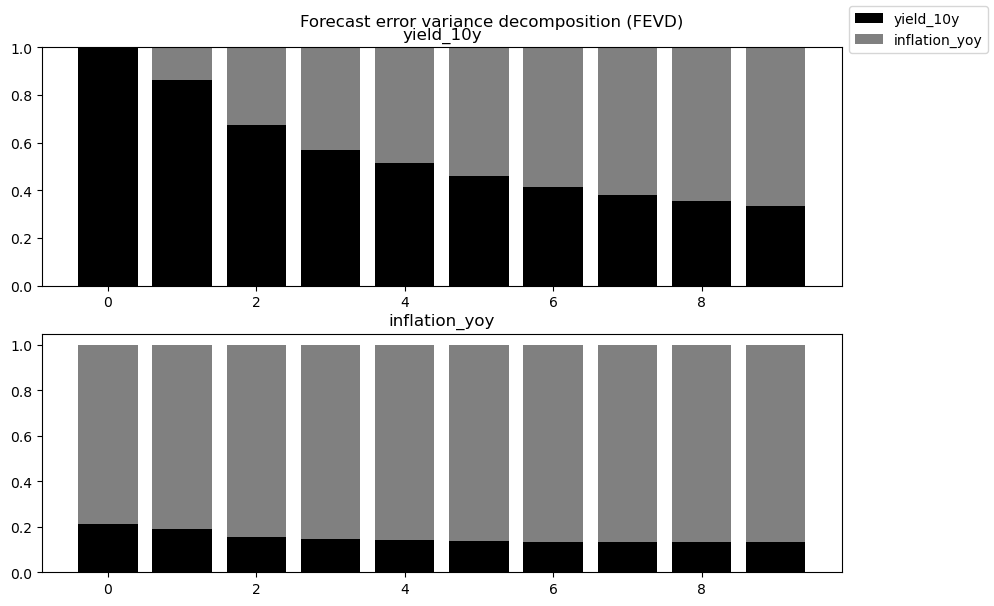

In [26]:
steps = 10  # horizonte FEVD
fevd = var_res.fevd(steps)

# Resumen en texto
print(fevd.summary())

# Gr√°fico por variable
_ = fevd.plot(figsize=(10,6))


## 6. Causalidad de Granger

Contrasta si los rezagos de una variable ayudan a predecir a la otra (m√°s all√° de sus propios rezagos).
- p-value < 0.05 ‚áí Rechazamos ‚Äúno causa‚Äù ‚áí hay causalidad de Granger en esa direcci√≥n.


In [27]:
# ¬øInflation_yoy causa (Granger) a yield_10y?
print(var_res.test_causality('yield_10y', ['inflation_yoy'], kind='f').summary())

# ¬øYield_10y causa (Granger) a inflation_yoy?
print(var_res.test_causality('inflation_yoy', ['yield_10y'], kind='f').summary())


Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         8.316          2.694   0.000 (3, 102)
----------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.451          2.694   0.232 (3, 102)
----------------------------------------------


### 7. Funciones de Impulso-Respuesta (IRF)

#### 7.1 IRF ortogonalizadas (Cholesky) con bandas de confianza

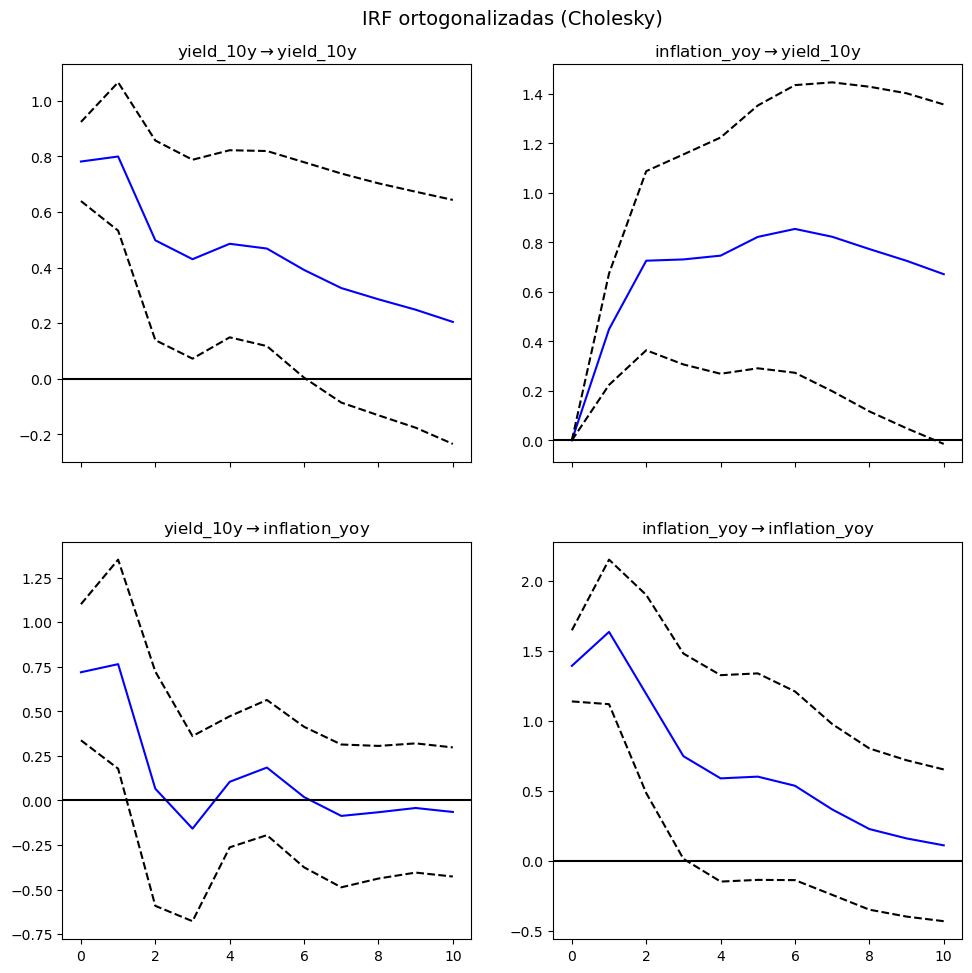

In [28]:
# Horizonte (a√±os)
h = 10

# IRF b√°sicas
irf = var_res.irf(h)

# Gr√°fico de IRF ortogonalizadas (Cholesky)
fig = irf.plot(orth=True)
fig.suptitle("IRF ortogonalizadas (Cholesky)", fontsize=14)

# Bandas de confianza por bootstrap Monte Carlo
# (repl=1000 si quieres m√°s precisi√≥n; tardar√° m√°s)
fig_ci = irf.errband_mc(orth=True, repl=500)  # devuelve fig y ejes con bandas


#### 7.2 IRF acumuladas (efecto total a lo largo del horizonte)

Text(0.5, 0.98, 'IRF acumuladas (orth)')

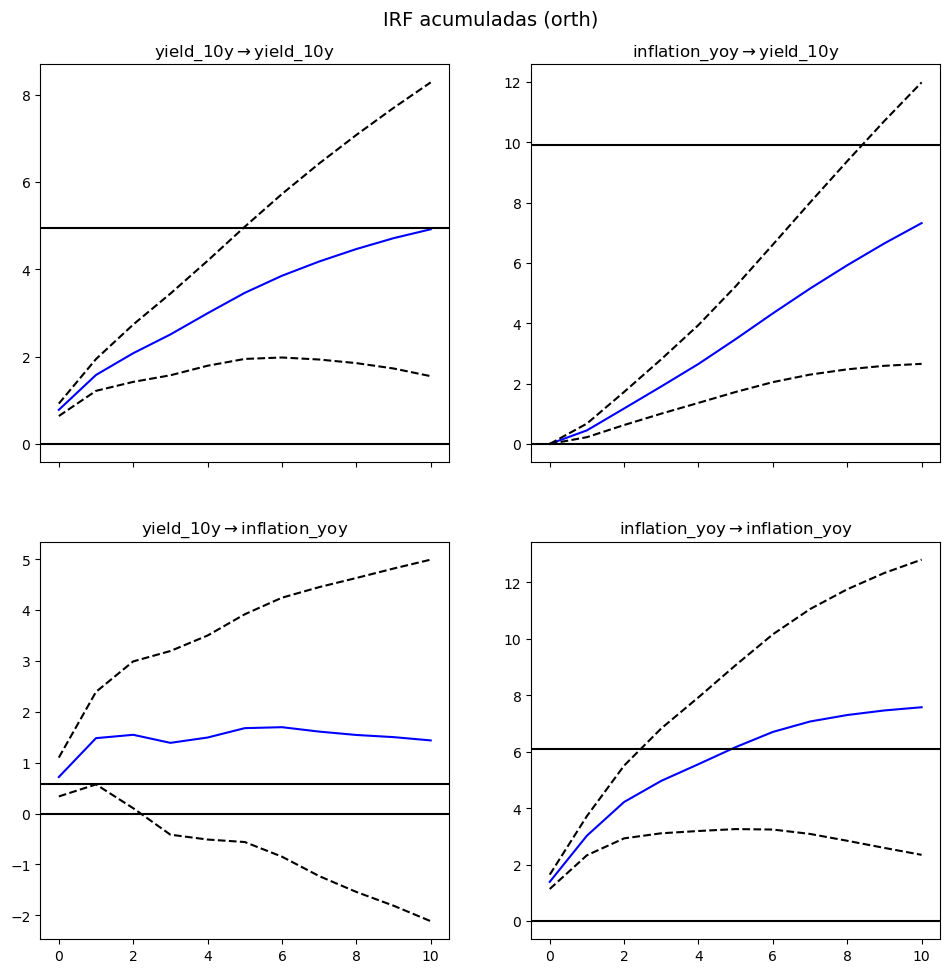

In [29]:
fig_cum = irf.plot_cum_effects(orth=True)
fig_cum.suptitle("IRF acumuladas (orth)", fontsize=14)


#### 7.3 Sensibilidad al orden de las variables
Cambiar el orden es buena pr√°ctica de robustez: primero inflaci√≥n, luego yield.

Text(0.5, 0.98, 'IRF orth con orden alternativo (inflaci√≥n primero)')

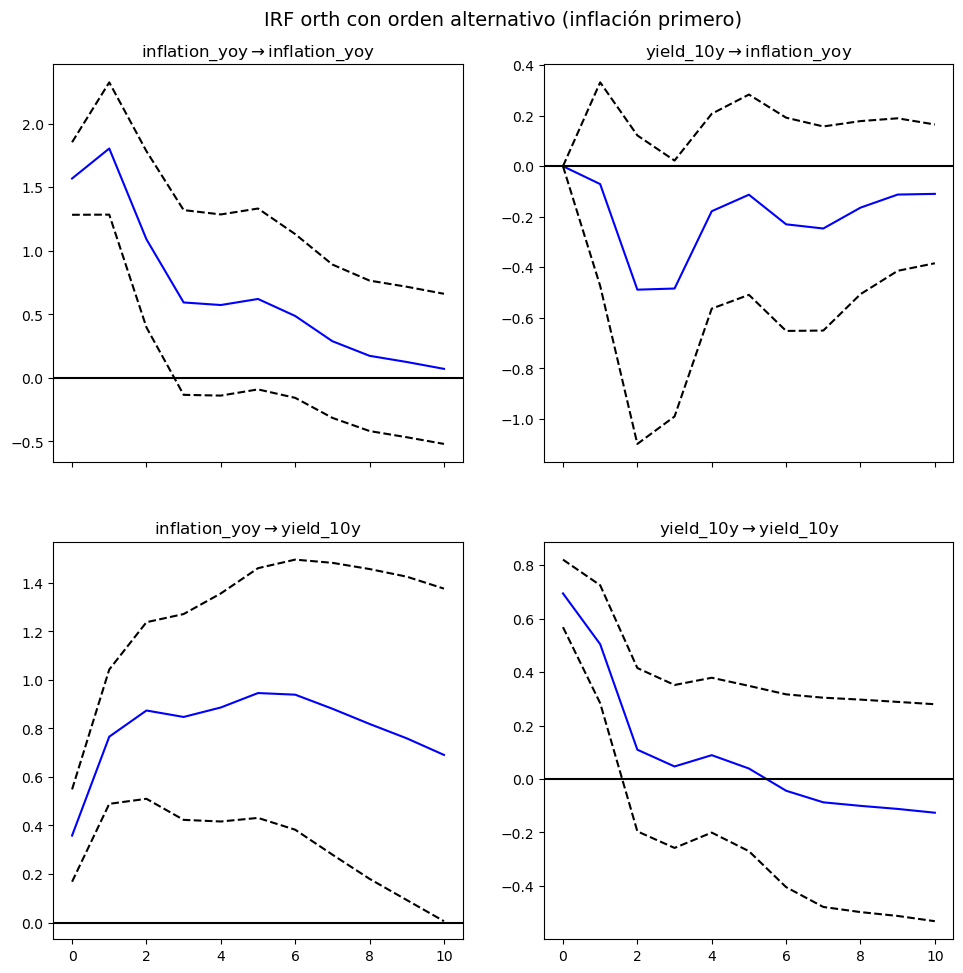

In [30]:
# Re-ajustamos el VAR con columnas reordenadas
from statsmodels.tsa.api import VAR
df_alt = df_clean[["inflation_yoy", "yield_10y"]].dropna().copy()
model_alt = VAR(df_alt)
var_res_alt = model_alt.fit(var_res.k_ar)  # usa el mismo n¬∫ de rezagos

irf_alt = var_res_alt.irf(h)
fig_alt = irf_alt.plot(orth=True)
fig_alt.suptitle("IRF orth con orden alternativo (inflaci√≥n primero)", fontsize=14)


#### 7.4 Guardar figuras a disco

In [31]:
fig.savefig("irf_orth.png", dpi=150, bbox_inches="tight")
fig_cum.savefig("irf_cum_orth.png", dpi=150, bbox_inches="tight")
fig_alt.savefig("irf_orth_alt_order.png", dpi=150, bbox_inches="tight")


###  Interpretaci√≥n Punto 7 (IRFs)

Shock inflaci√≥n ‚Üí Yield 10Y: impacto fuerte y sostenido, los bonos suben porque el mercado exige m√°s rentabilidad.

Shock Yield 10Y ‚Üí Inflaci√≥n: efecto d√©bil y pasajero, incluso negativo (tipos altos enfr√≠an la econom√≠a).

Inflaci√≥n sobre s√≠ misma: persistente, pero va perdiendo fuerza.

Yield sobre s√≠ mismo: se corrige r√°pido.

IRFs acumuladas: confirman que la inflaci√≥n arrastra a los yields, no al rev√©s.

Sensibilidad al orden: los resultados son robustos, no dependen del orden de variables.

üìå Conclusi√≥n clara:
La inflaci√≥n lidera y los yields siguen.

#### Preparar el dataset USA para el pipeline


In [32]:
df_usa = (
    df_clean[['Year', 'yield_10y', 'inflation_yoy']]
      .dropna()
      .copy()
)

df_usa['Year'] = df_usa['Year'].astype(int)
df_usa = df_usa.set_index('Year').sort_index()

#### Define el pipeline (elige rezagos autom√°ticamente)

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson

def run_country_pipeline_auto(df, country_name, steps=10, maxlags=8, crit="aic"):
    """
    Pipeline VAR completo con selecci√≥n autom√°tica de rezagos.
    df: DataFrame con index=Year y columnas ['yield_10y','inflation_yoy']
    steps: horizonte de forecast
    maxlags: rezago m√°ximo a evaluar
    crit: 'aic' | 'bic' | 'hqic' | 'fpe'
    """
    df = df[['yield_10y','inflation_yoy']].dropna().copy()
    model = VAR(df)

    # 1) Selecci√≥n de rezagos
    sel = model.select_order(maxlags=maxlags)
    best_lag = getattr(sel, crit)
    print(f"\n[{country_name}] Rezagos √≥ptimos por {crit.upper()}: {best_lag}")

    # 2) Ajuste
    res = model.fit(best_lag)
    print(res.summary())

    # 3) Diagn√≥stico (r√°pido)
    print("\n--- Diagn√≥stico ---")
    for col in res.resid.columns:
        lb = acorr_ljungbox(res.resid[col].dropna(), lags=[10], return_df=True)
        print(f"Ljung-Box {col} (lag=10): p-value={lb['lb_pvalue'].iloc[0]:.4f}")
    dw = durbin_watson(res.resid.values)
    for c,v in zip(res.resid.columns, dw):
        print(f"Durbin‚ÄìWatson {c}: {v:.2f}")
    print("Estabilidad:", res.is_stable(verbose=True))

    # 4) Forecast con bandas
    k = res.k_ar
    mean, low, up = res.forecast_interval(res.endog[-k:], steps=steps, alpha=0.05)
    idx_future = range(df.index.max()+1, df.index.max()+1+steps)
    f_mean = pd.DataFrame(mean, index=idx_future, columns=res.names)
    f_low  = pd.DataFrame(low,  index=idx_future, columns=res.names)
    f_up   = pd.DataFrame(up,   index=idx_future, columns=res.names)

    plt.figure(figsize=(11,5))
    for col in res.names:
        plt.plot(df.index, df[col], label=f"{col} (hist.)")
        plt.plot(f_mean.index, f_mean[col], "--", label=f"{col} (fcst)")
        plt.fill_between(f_mean.index, f_low[col], f_up[col], alpha=0.2)
    plt.axvline(df.index.max(), color="gray", linestyle="--", alpha=0.7)
    plt.title(f"{country_name} ‚Äì Forecast VAR (95% IC)")
    plt.xlabel("A√±o"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()

    # 5) FEVD
    fevd = res.fevd(steps)
    print("\n--- FEVD ---")
    print(fevd.summary())
    fevd.plot(figsize=(9,5)); plt.show()

    # 6) Granger
    print("\n--- Granger ---")
    print(res.test_causality('yield_10y',['inflation_yoy'], kind='f').summary())
    print(res.test_causality('inflation_yoy',['yield_10y'], kind='f').summary())

    # 7) IRFs (orth y acumuladas)
    irf = res.irf(steps)
    irf.plot(orth=True); plt.suptitle(f"{country_name} ‚Äì IRF orth"); plt.show()
    irf.plot_cum_effects(orth=True); plt.suptitle(f"{country_name} ‚Äì IRF acumuladas"); plt.show()

    return res, {"forecast_mean": f_mean, "forecast_low": f_low, "forecast_up": f_up}, fevd, irf, best_lag


#### Ejecutar el pipeline para USA

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[USA] Rezagos √≥ptimos por AIC: 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:27:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.893584
Nobs:                     58.0000    HQIC:                  0.589963
Log likelihood:          -162.088    FPE:                    1.48974
AIC:                     0.396236    Det(Omega_mle):         1.18615
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.096240         0.256867           -0.375           0.708
L1.yield_10y             0.726405         0.147355            4.930           0.000
L1.inflat

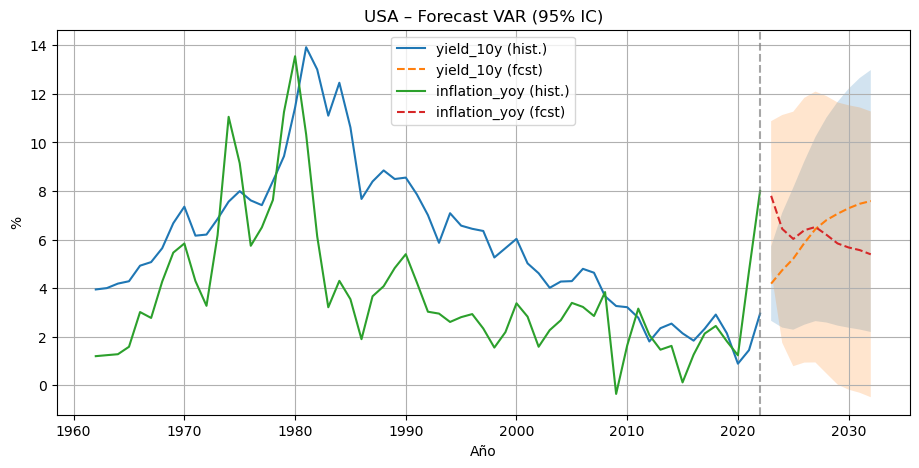


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.860953       0.139047
2     0.672574       0.327426
3     0.571081       0.428919
4     0.513006       0.486994
5     0.461214       0.538786
6     0.415154       0.584846
7     0.380437       0.619563
8     0.355117       0.644883
9     0.335671       0.664329

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.210270       0.789730
1     0.192578       0.807422
2     0.154725       0.845275
3     0.146232       0.853768
4     0.141077       0.858923
5     0.138470       0.861530
6     0.133939       0.866061
7     0.132624       0.867376
8     0.132270       0.867730
9     0.132055       0.867945


None


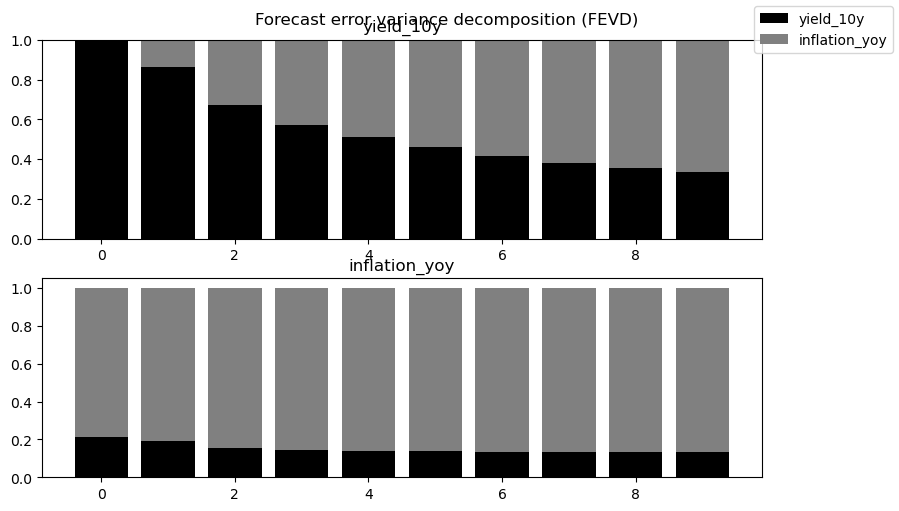


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         8.316          2.694   0.000 (3, 102)
----------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.451          2.694   0.232 (3, 102)
----------------------------------------------


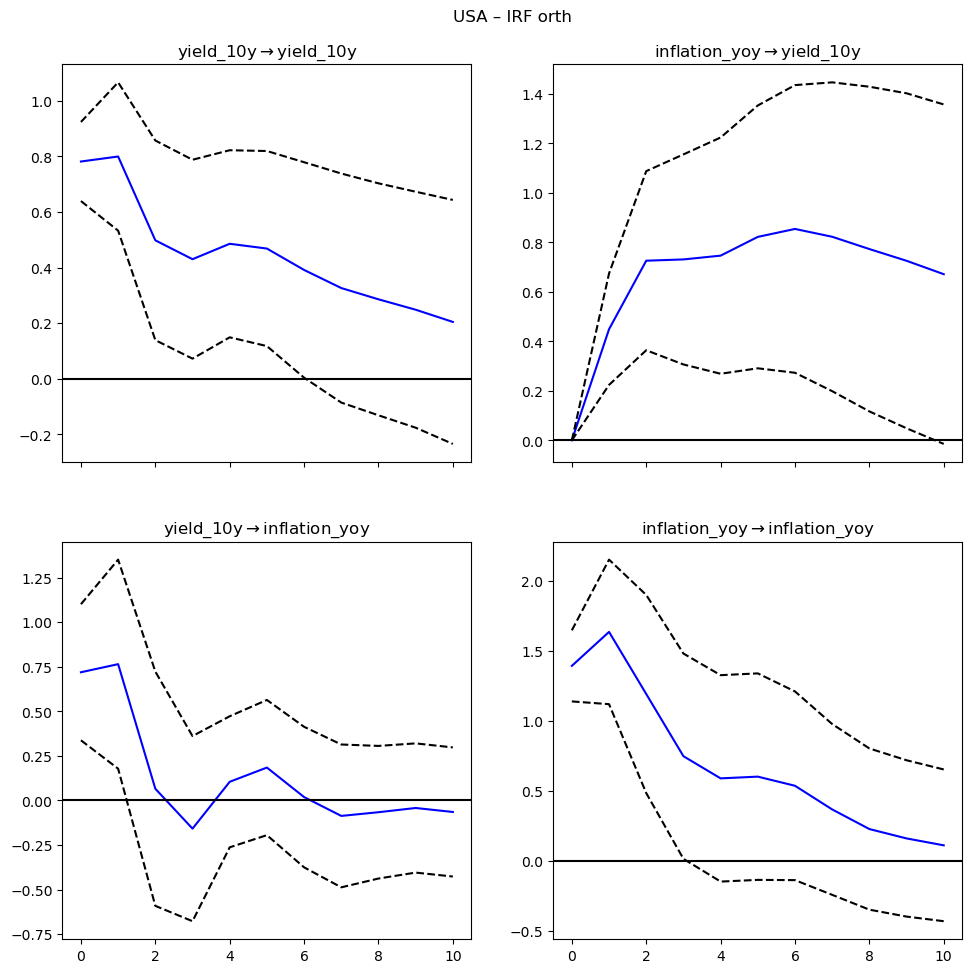

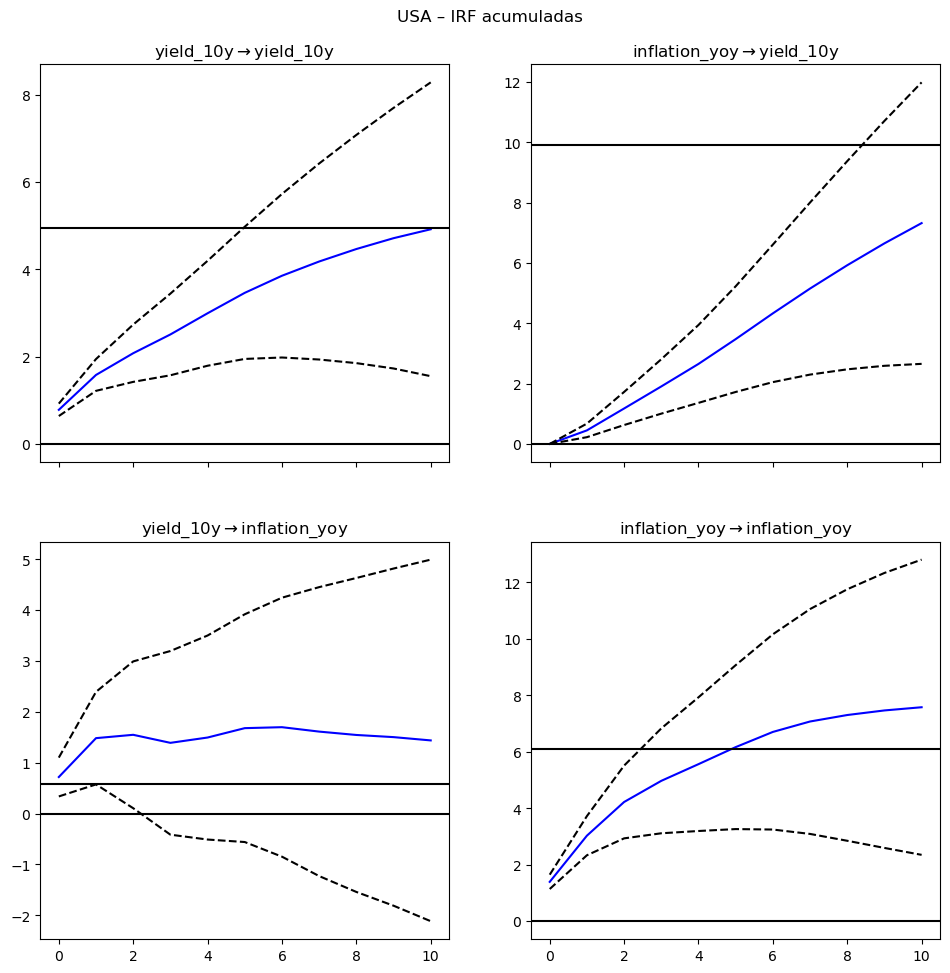

Lag elegido (AIC): 3


In [34]:
usa_results, usa_fcst, usa_fevd, usa_irf, usa_bestlag = run_country_pipeline_auto(
    df_usa, country_name="USA", steps=10, maxlags=8, crit="aic"
)
print("Lag elegido (AIC):", usa_bestlag)


### Detectar la columna 10Y de Alemania en yields.csv

In [37]:
import pandas as pd, re

# Cargar si no esta ya en memoria:
yields = pd.read_csv("/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin t√≠tulo/yields.csv")

# columnas 10Y tipo 'US10', 'DE10', etc.
ten_cols = [c for c in yields.columns if re.fullmatch(r"[A-Z]{2}\d{2}", c) and c.endswith("10")]
print("10Y detectadas (primeras 30):", ten_cols[:30])

# Intento autom√°tico para Alemania
candidatos_de = [c for c in ten_cols if c.startswith(("DE","GE","BD","GM"))]
print("Candidatos Alemania:", candidatos_de)

# Si aparece 'DE10', √∫sala; si no, toma el primer candidato que salga.
col_de = "DE10" if "DE10" in ten_cols else (candidatos_de[0] if candidatos_de else None)
print("Columna usada para Alemania 10Y:", col_de)


10Y detectadas (primeras 30): ['AU10', 'BE10', 'CA10', 'CN10', 'DK10', 'FR10', 'DE10', 'GR10', 'HK10', 'IN10', 'ID10', 'IE10', 'IT10', 'JP10', 'KR10', 'MY10', 'NL10', 'NZ10', 'NO10', 'PL10', 'PT10', 'SG10', 'ZA10', 'ES10', 'SE10', 'TW10', 'TH10', 'TR10', 'GB10', 'US10']
Candidatos Alemania: ['DE10']
Columna usada para Alemania 10Y: DE10


### Anualizar yields USA + Alemania

In [38]:
yields_yr = yields.copy()
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

col_us = "US10"   # USA 10Y
col_de = "DE10"   # Alemania 10Y

y_ann = (
    yields_yr[['Year', col_us, col_de]]
      .groupby('Year', as_index=False)
      .mean()
      .rename(columns={col_us:'yield_10y_US', col_de:'yield_10y_DE'})
)


### Inflaci√≥n del Banco Mundial (USA + Alemania)

In [41]:
wb = pd.read_csv("/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin t√≠tulo/world_bank_data_2025.csv")

wb_small = wb.rename(columns={
    'country_name':'Country',
    'year':'Year',
    'Inflation (CPI %)':'inflation_yoy'
})[['Country','Year','inflation_yoy']].dropna()

infl_us = wb_small.query("Country == 'United States'")[['Year','inflation_yoy']].rename(columns={'inflation_yoy':'inflation_yoy_US'})
infl_de = wb_small.query("Country == 'Germany'")[['Year','inflation_yoy']].rename(columns={'inflation_yoy':'inflation_yoy_DE'})


### Construir datasets y lanzar el pipeline

#### Carga el CSV de Alemania

In [43]:
import pandas as pd

# === 1) Cargar CSV Alemania desde FRED ===
de_raw = pd.read_csv("/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin t√≠tulo/IRLTLT01DEM156N.csv")

# Normalizar columnas
de_raw['observation_date'] = pd.to_datetime(de_raw['observation_date'], errors='coerce')
de_raw = de_raw.rename(columns={'IRLTLT01DEM156N':'yield_10y'})

# === 2) Pasar de mensual ‚Üí anual (promedio) ===
de_annual = de_raw.set_index('observation_date').resample('YE').mean()
de_annual.index = de_annual.index.year
de_annual.index.name = 'Year'
de_annual = de_annual.reset_index()

print("Alemania yields anuales:", de_annual['Year'].min(), "‚Üí", de_annual['Year'].max())
display(de_annual.head())

# === 3) Inflaci√≥n Alemania desde World Bank ===
wb_small = wb.rename(columns={
    'country_name':'Country',
    'year':'Year',
    'Inflation (CPI %)':'inflation_yoy'
})[['Country','Year','inflation_yoy']].dropna()

infl_de = wb_small.query("Country == 'Germany'")[['Year','inflation_yoy']]

# === 4) Merge yields + inflaci√≥n ===
df_germany = (
    de_annual.merge(infl_de, on='Year', how='inner')
             .set_index('Year').sort_index()
)

print("Alemania combinado:", df_germany.index.min(), "‚Üí", df_germany.index.max())
display(df_germany.tail())


Alemania yields anuales: 1956 ‚Üí 2025


Year  yield_10y
0  1956   6.912500
1  1957   7.516667
2  1958   6.783333
3  1959   5.766667
4  1960   6.425000

Alemania combinado: 2010 ‚Üí 2024


yield_10y  inflation_yoy
Year                          
2020  -0.511024       0.144878
2021  -0.373821       3.066667
2022   1.142583       6.872574
2023   2.434599       5.946437
2024   2.321084       2.256498

### Alemania: cortar a 2010‚Äì2024 y correr el

[Germany] N=15 | maxlags sugerido=3

[Germany (2010‚Äì2024)] Rezagos √≥ptimos por AIC: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:44:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.618713
Nobs:                     14.0000    HQIC:                 -0.917947
Log likelihood:          -27.4821    FPE:                   0.415156
AIC:                    -0.892594    Det(Omega_mle):        0.281559
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.166027         0.219234           -0.757           0.449
L1.yield_10y             0.612594      

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


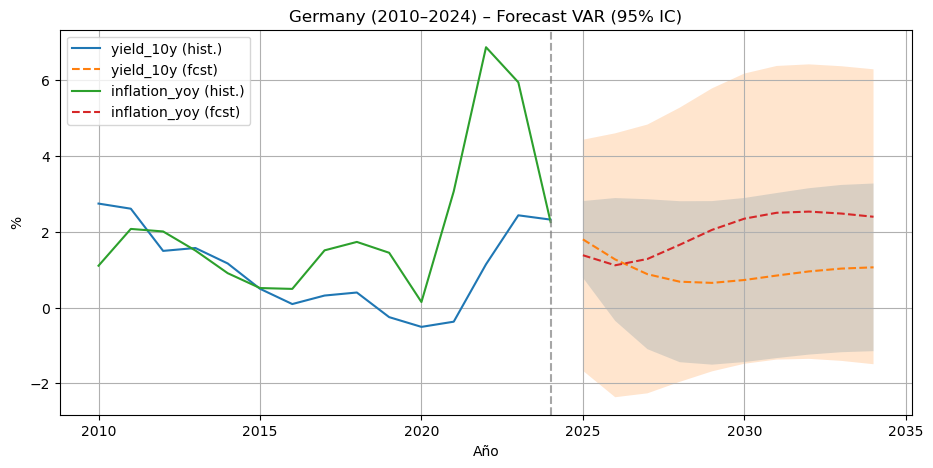


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.910424       0.089576
2     0.836596       0.163404
3     0.791540       0.208460
4     0.772434       0.227566
5     0.770204       0.229796
6     0.772758       0.227242
7     0.773377       0.226623
8     0.771993       0.228007
9     0.770538       0.229462

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.563252       0.436748
1     0.502239       0.497761
2     0.485512       0.514488
3     0.505551       0.494449
4     0.527701       0.472299
5     0.536082       0.463918
6     0.535563       0.464437
7     0.533641       0.466359
8     0.533380       0.466620
9     0.534259       0.465741


None


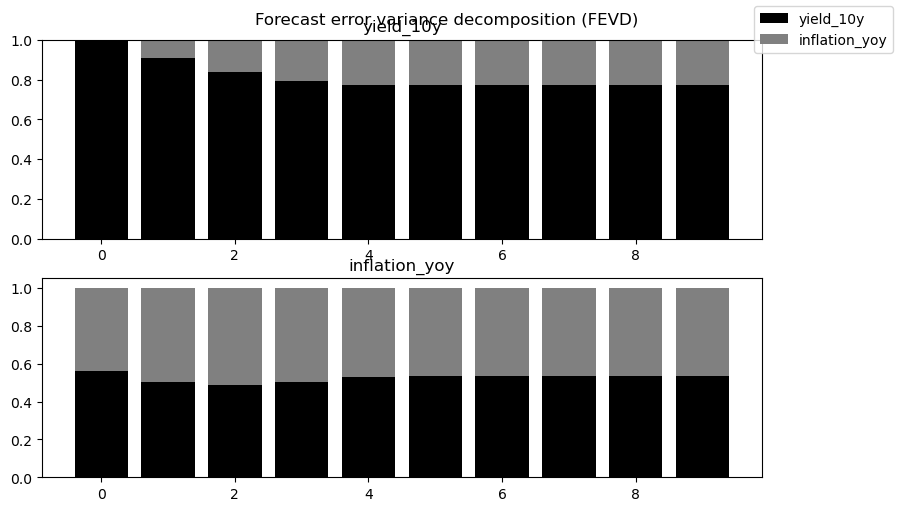


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         9.983          4.301   0.005 (1, 22)
---------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         2.602          4.301   0.121 (1, 22)
---------------------------------------------


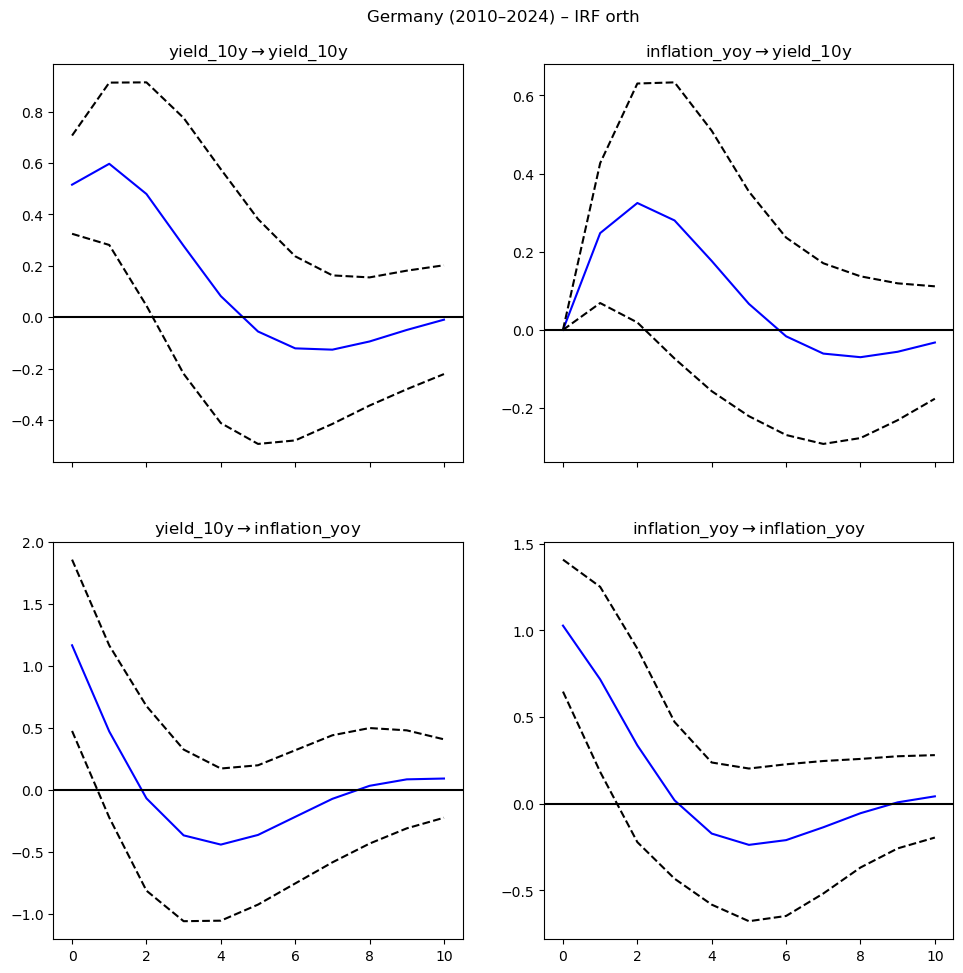

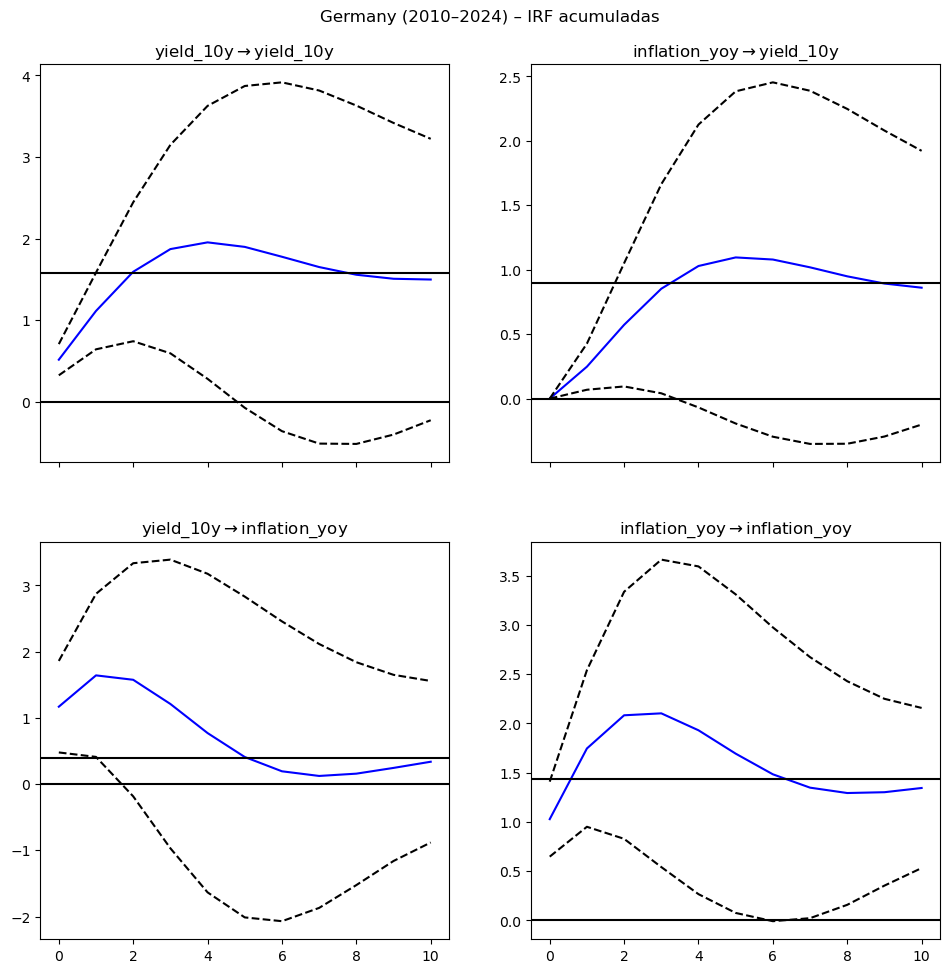

Germany (2010‚Äì2024) ‚Äì lag elegido: 1


In [44]:
# --- Alemania 2010‚Äì2024 ---
df_germany_2010_24 = df_germany.loc[2010:2024].copy()

N = len(df_germany_2010_24)
safe_maxlags = max(1, min(3, (N - 3)//2))   # con ~15 a√±os suele salir 1‚Äì2
print(f"[Germany] N={N} | maxlags sugerido={safe_maxlags}")

de_res, de_fcst, de_fevd, de_irf, de_bestlag = run_country_pipeline_auto(
    df_germany_2010_24, country_name="Germany (2010‚Äì2024)",
    steps=10, maxlags=safe_maxlags, crit="aic"
)
print("Germany (2010‚Äì2024) ‚Äì lag elegido:", de_bestlag)


### USA: mismo corte 2010‚Äì2024

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

def run_country_pipeline_auto(df, country_name, steps=5, maxlags=2, crit="aic"):
    """
    df: index=Year (int), columnas ['yield_10y','inflation_yoy']
    steps: horizonte de forecast
    maxlags: rezago m√°ximo permitido (luego se capea autom√°ticamente)
    """
    # 0) Formato y limpieza
    df = df[['yield_10y','inflation_yoy']].dropna().copy()
    df.index = df.index.astype(int)
    df = df.sort_index()

    # 1) C√°lculo de un maxlags seguro seg√∫n n¬∫ de observaciones
    N = len(df)
    k_endog = df.shape[1]  # 2
    safe_max = max(1, min(maxlags, (N - 5)//k_endog))  # cap defensivo
    if safe_max < 1:
        raise ValueError(f"Datos insuficientes (N={N}). Reduce rango de a√±os o a√±ade datos.")
    if safe_max < maxlags:
        print(f"[{country_name}] maxlags reducido de {maxlags} a {safe_max} por N={N}")

    # 2) Selecci√≥n de rezagos y ajuste
    model = VAR(df)
    sel = model.select_order(maxlags=safe_max)
    best_lag = getattr(sel, crit)
    if best_lag is None or best_lag < 1:
        best_lag = min(1, safe_max)
    print(f"\n[{country_name}] Rezagos √≥ptimos por {crit.upper()}: {best_lag}")
    res = model.fit(best_lag)
    print(res.summary())

    # 3) Diagn√≥stico robusto (Ljung‚ÄìBox con lag seguro)
    print("\n--- Diagn√≥stico ---")
    nres = len(res.resid)
    lb_lag = max(1, min(10, nres - 2, 2*best_lag))  # evita el error por tama√±os
    for col in res.resid.columns:
        if lb_lag >= 1:
            lb = acorr_ljungbox(res.resid[col].dropna(), lags=[lb_lag], return_df=True)
            print(f"Ljung-Box {col} (lag={lb_lag}): p={lb['lb_pvalue'].iloc[0]:.4f}")
        else:
            print(f"Ljung-Box {col}: saltado (muy pocas observaciones)")
    dw = durbin_watson(res.resid.values)
    for c, v in zip(res.resid.columns, dw):
        print(f"Durbin‚ÄìWatson {c}: {v:.2f}")
    print("Estabilidad:", res.is_stable(verbose=True))

    # 4) Forecast con bandas (95%)
    k = res.k_ar
    mean, low, up = res.forecast_interval(res.endog[-k:], steps=steps, alpha=0.05)
    idx_future = range(df.index.max()+1, df.index.max()+1+steps)
    f_mean = pd.DataFrame(mean, index=idx_future, columns=res.names)
    f_low  = pd.DataFrame(low,  index=idx_future, columns=res.names)
    f_up   = pd.DataFrame(up,   index=idx_future, columns=res.names)

    plt.figure(figsize=(11,5))
    for col in res.names:
        plt.plot(df.index, df[col], label=f"{col} (hist.)")
        plt.plot(f_mean.index, f_mean[col], "--", label=f"{col} (fcst)")
        plt.fill_between(f_mean.index, f_low[col], f_up[col], alpha=0.2)
    plt.axvline(df.index.max(), color="gray", linestyle="--", alpha=0.7)
    plt.title(f"{country_name} ‚Äì Forecast VAR (95% IC)")
    plt.xlabel("A√±o"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()

    # 5) FEVD
    fevd = res.fevd(steps)
    print("\n--- FEVD ---")
    print(fevd.summary())
    fevd.plot(figsize=(9,5)); plt.show()

    # 6) Causalidad de Granger
    print("\n--- Granger ---")
    print(res.test_causality('yield_10y', ['inflation_yoy'], kind='f').summary())
    print(res.test_causality('inflation_yoy', ['yield_10y'], kind='f').summary())

    # 7) IRFs (orth y acumuladas)
    irf = res.irf(steps)
    irf.plot(orth=True); plt.suptitle(f"{country_name} ‚Äì IRF orth"); plt.show()
    irf.plot_cum_effects(orth=True); plt.suptitle(f"{country_name} ‚Äì IRF acumuladas"); plt.show()

    return res, {"forecast_mean": f_mean, "forecast_low": f_low, "forecast_up": f_up}, fevd, irf, best_lag


In [46]:
df_usa_2010_24     = df_usa.loc[2010:2024].copy()
df_germany_2010_24 = df_germany.loc[2010:2024].copy()

print("USA 2010‚Äì2024:", df_usa_2010_24.index.min(), "‚Üí", df_usa_2010_24.index.max(), "| N=", len(df_usa_2010_24))
print("DE  2010‚Äì2024:", df_germany_2010_24.index.min(), "‚Üí", df_germany_2010_24.index.max(), "| N=", len(df_germany_2010_24))


USA 2010‚Äì2024: 2010 ‚Üí 2022 | N= 13
DE  2010‚Äì2024: 2010 ‚Üí 2024 | N= 15



[USA (2010‚Äì2024)] Rezagos √≥ptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:45:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.878916
Nobs:                     11.0000    HQIC:                  -1.46865
Log likelihood:          -14.3931    FPE:                   0.333817
AIC:                     -1.24064    Det(Omega_mle):        0.157781
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    2.996691         0.820944            3.650           0.000
L1.yield_10y             0.380733         0.296424            1.284           0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


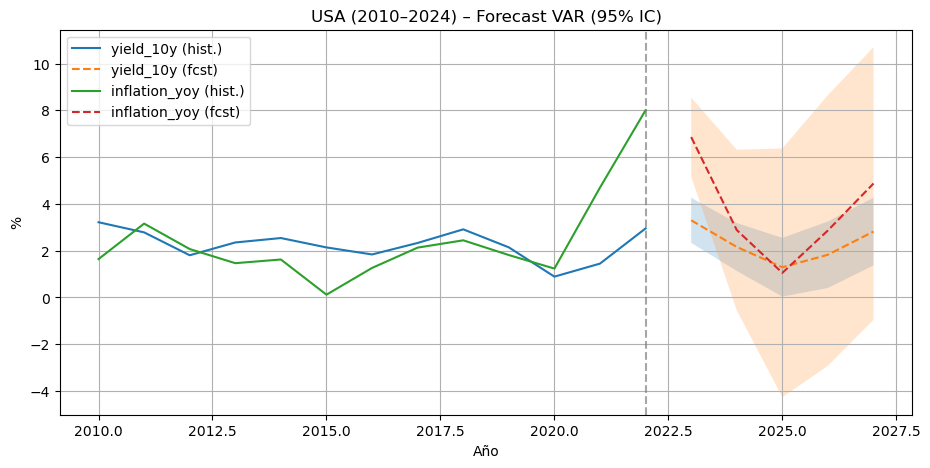


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.994611       0.005389
2     0.992842       0.007158
3     0.994395       0.005605
4     0.992982       0.007018

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.121961       0.878039
1     0.563654       0.436346
2     0.774076       0.225924
3     0.801457       0.198543
4     0.803017       0.196983


None


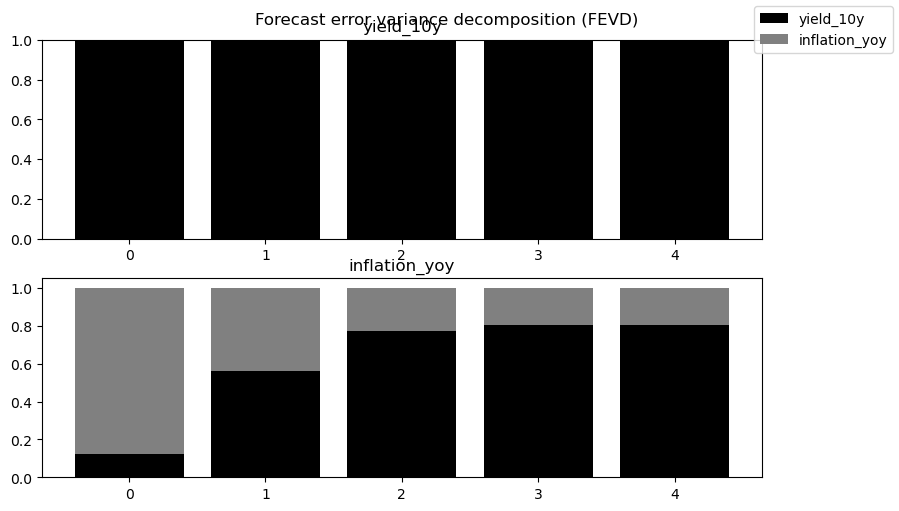


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
       0.05184          3.885   0.950 (2, 12)
---------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         13.48          3.885   0.001 (2, 12)
---------------------------------------------


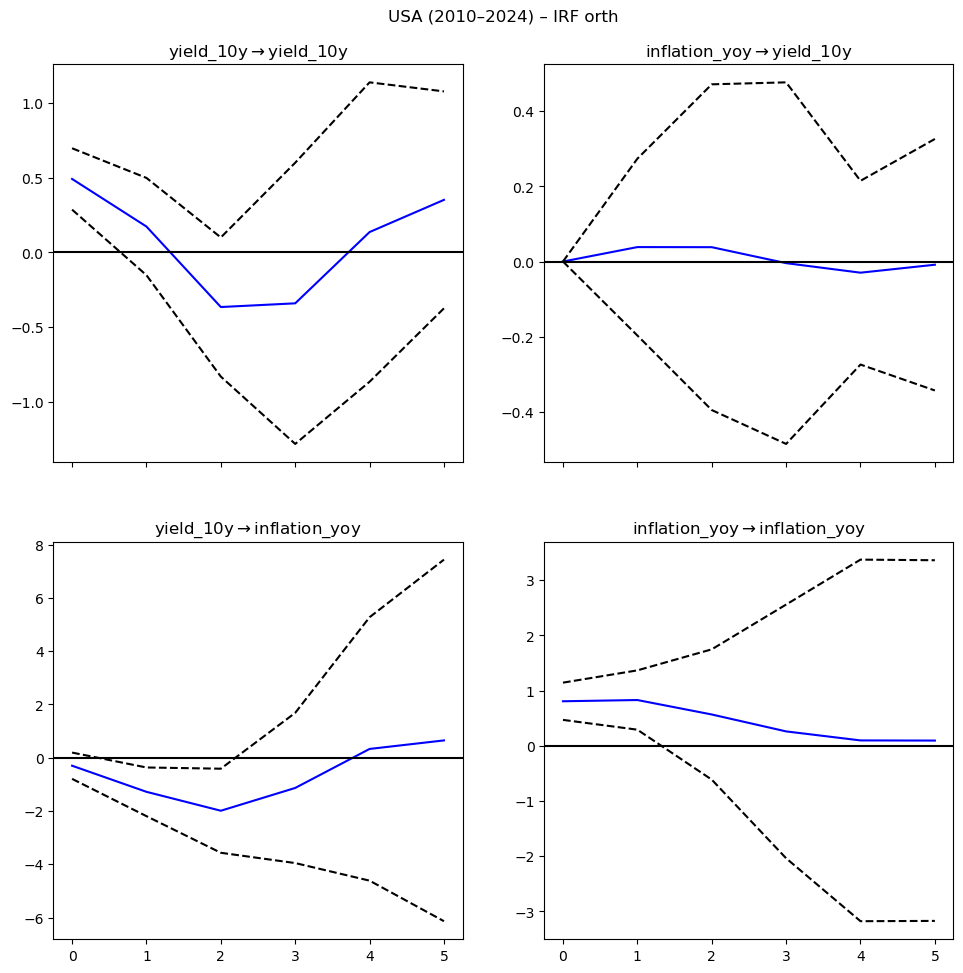

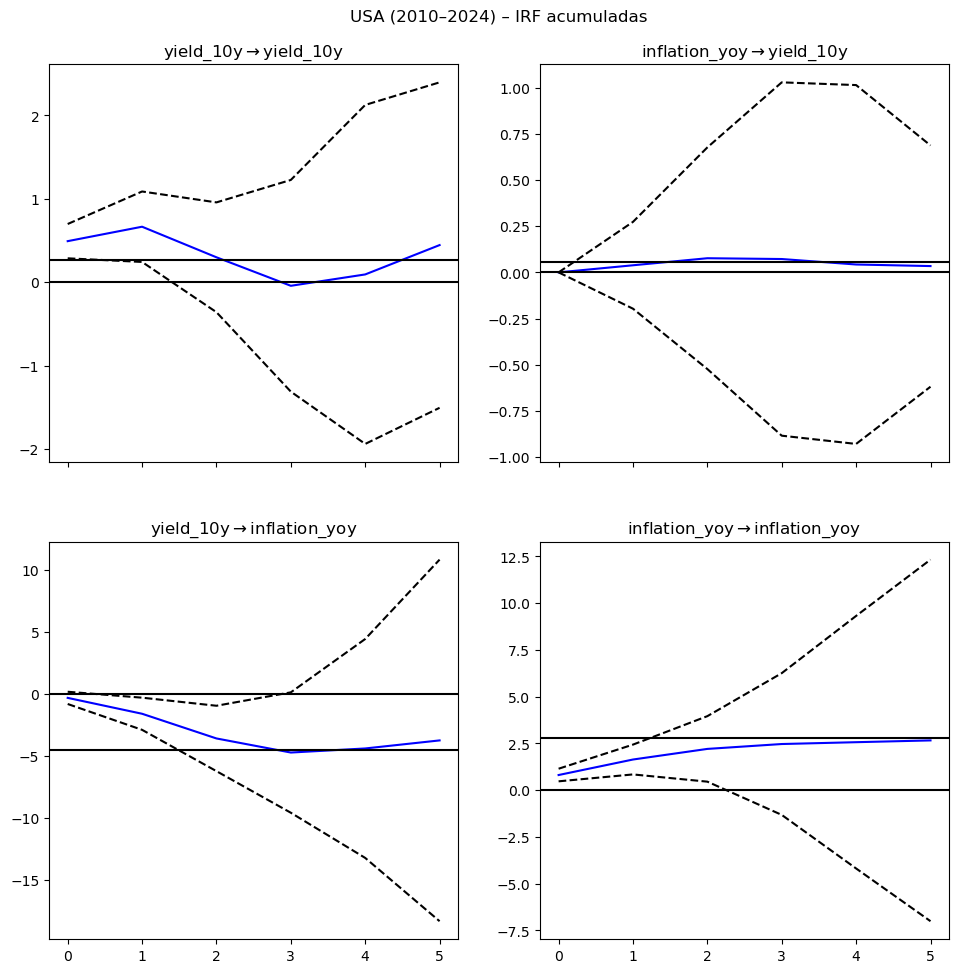

USA (2010‚Äì2024) ‚Äì lag elegido: 2


In [47]:
# USA
us_res, us_fcst, us_fevd, us_irf, us_bestlag = run_country_pipeline_auto(
    df_usa_2010_24, country_name="USA (2010‚Äì2024)", steps=5, maxlags=2, crit="aic"
)
print("USA (2010‚Äì2024) ‚Äì lag elegido:", us_bestlag)




In [48]:
assert {'yield_10y','inflation_yoy'}.issubset(df_usa.columns), "df_usa no tiene las columnas correctas"
df_usa_2010_24 = df_usa.loc[2010:2024].copy()
print("Rango USA recortado:", df_usa_2010_24.index.min(), "‚Üí", df_usa_2010_24.index.max(), "| N=", len(df_usa_2010_24))
print(df_usa_2010_24.head(), "\n", df_usa_2010_24.tail())


Rango USA recortado: 2010 ‚Üí 2022 | N= 13
      yield_10y  inflation_yoy
Year                          
2010    3.21506       1.640043
2011    2.78164       3.156842
2012    1.80344       2.069337
2013    2.35016       1.464833
2014    2.53956       1.622223 
       yield_10y  inflation_yoy
Year                          
2018   2.911245       2.442583
2019   2.141400       1.812210
2020   0.889203       1.233584
2021   1.446853       4.697859
2022   2.950562       8.002800


In [49]:
# A√±os disponibles en cada fuente (USA)
print("Yields USA (y_ann):", y_ann[['Year','yield_10y_US']].dropna()['Year'].min(), "‚Üí", y_ann[['Year','yield_10y_US']].dropna()['Year'].max())
print("Inflaci√≥n USA (infl_us):", infl_us['Year'].min(), "‚Üí", infl_us['Year'].max())

# Qu√© a√±os faltan en cada una dentro de 2010‚Äì2024
yrs = set(range(2010, 2025))
y_ok  = set(y_ann.loc[y_ann['yield_10y_US'].notna(), 'Year'])
i_ok  = set(infl_us['Year'])
print("Faltan en yields:", sorted(yrs - y_ok))
print("Faltan en inflaci√≥n:", sorted(yrs - i_ok))


Yields USA (y_ann): 1970 ‚Üí 2020
Inflaci√≥n USA (infl_us): 2010 ‚Üí 2024
Faltan en yields: [2021, 2022, 2023, 2024]
Faltan en inflaci√≥n: []


#### Anualizar DGS10 y crear Year

In [50]:
import pandas as pd

# Cargar CSV DGS10 (tiene columnas: observation_date, DGS10)
dgs = pd.read_csv("/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin t√≠tulo/DGS10.csv")

# Limpiar tipos
dgs["observation_date"] = pd.to_datetime(dgs["observation_date"], errors="coerce")
dgs["DGS10"] = pd.to_numeric(dgs["DGS10"], errors="coerce")
dgs = dgs.dropna(subset=["observation_date", "DGS10"]).sort_values("observation_date")

# Resample anual (promedio) y crear Year de forma expl√≠cita
dgs_ann = (
    dgs.set_index("observation_date")
       .resample("YE").mean()                  # promedio anual
       .assign(Year=lambda x: x.index.year)    # crear Year desde el √≠ndice
       .reset_index(drop=True)[["Year", "DGS10"]]
       .rename(columns={"DGS10": "yield_10y"})
)

# Filtrar 2021‚Äì2024 (o lo que tengas)
dgs_ann = dgs_ann.query("Year >= 2021").copy()

print(dgs_ann.head())


   Year  yield_10y
1  2021   1.446853
2  2022   2.950562
3  2023   3.959000
4  2024   4.207960
5  2025   4.392437


#### Unir con tu serie USA previa

In [52]:
# Recalcular US10 anual (hasta 2020) desde tu yields.csv
yields_yr = yields.copy()
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

us10_ann_old = (
    yields_yr.groupby('Year')['US10'].mean()
             .rename('yield_10y')
             .reset_index()
)

print("US10 anualizado (hasta 2020):")
print(us10_ann_old.tail())


US10 anualizado (hasta 2020):
    Year  yield_10y
46  2016   1.833551
47  2017   2.328483
48  2018   2.915869
49  2019   2.138607
50  2020   0.978000


In [53]:
# us10_ann_old: tu serie hist√≥rica hasta 2020 (Year, yield_10y)
us10_full = (
    pd.concat([us10_ann_old, dgs_ann], ignore_index=True)
      .sort_values("Year")
      .drop_duplicates("Year", keep="last")
      .reset_index(drop=True)
)

print(us10_full.tail(15))


    Year  yield_10y
41  2011   2.762909
42  2012   1.788892
43  2013   2.341008
44  2014   2.529388
45  2015   2.133728
46  2016   1.833551
47  2017   2.328483
48  2018   2.915869
49  2019   2.138607
50  2020   0.978000
51  2021   1.446853
52  2022   2.950562
53  2023   3.959000
54  2024   4.207960
55  2025   4.392437


### Construir df_usa_2010_24 para el VAR

In [54]:
# Aseg√∫rate de tener infl_us: (Year, inflation_yoy)
df_usa_2010_24 = (
    us10_full.merge(infl_us, on="Year", how="inner")
             .query("Year >= 2010 and Year <= 2024")
             .set_index("Year")
             .sort_index()
             .dropna()
)

print(df_usa_2010_24.tail(10))


      yield_10y  inflation_yoy_US
Year                             
2015   2.133728          0.118627
2016   1.833551          1.261583
2017   2.328483          2.130110
2018   2.915869          2.442583
2019   2.138607          1.812210
2020   0.978000          1.233584
2021   1.446853          4.697859
2022   2.950562          8.002800
2023   3.959000          4.116338
2024   4.207960          2.949525


### USA (2015‚Äì2024) ‚Äì VAR robusto con cap autom√°tico de lags

[USA 2015‚Äì2024] N=10
Rezago √≥ptimo (AIC, cap=2): 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:47:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.658256
Nobs:                     8.00000    HQIC:                  -1.42731
Log likelihood:          -9.67278    FPE:                   0.722611
AIC:                    -0.757558    Det(Omega_mle):        0.273652
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    4.597791         1.559055            2.949           0.003
L1.yield_10y             0.874699         0.373774            2.340       

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


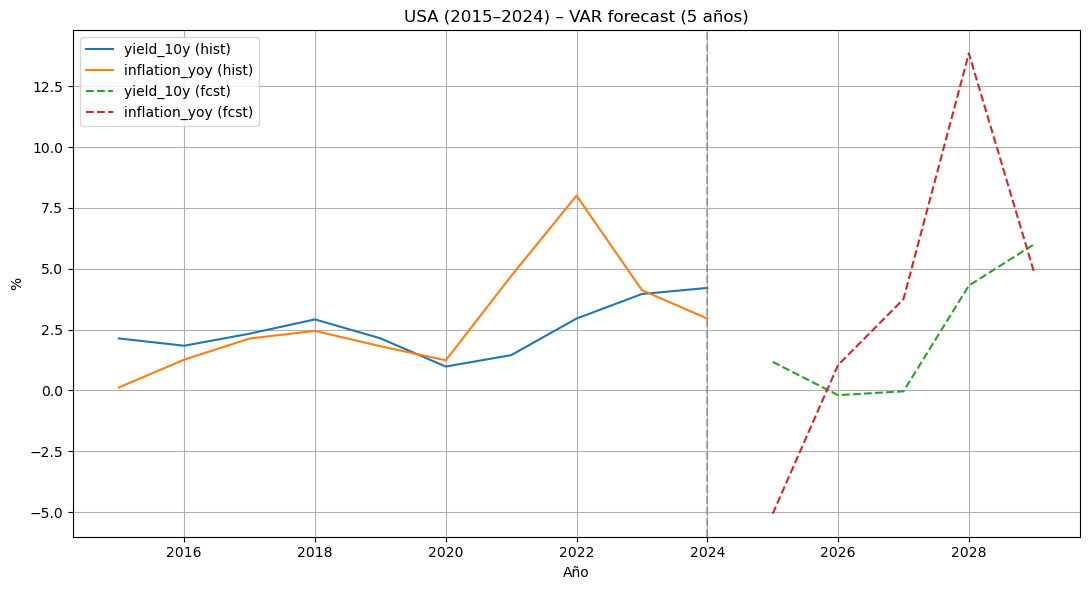

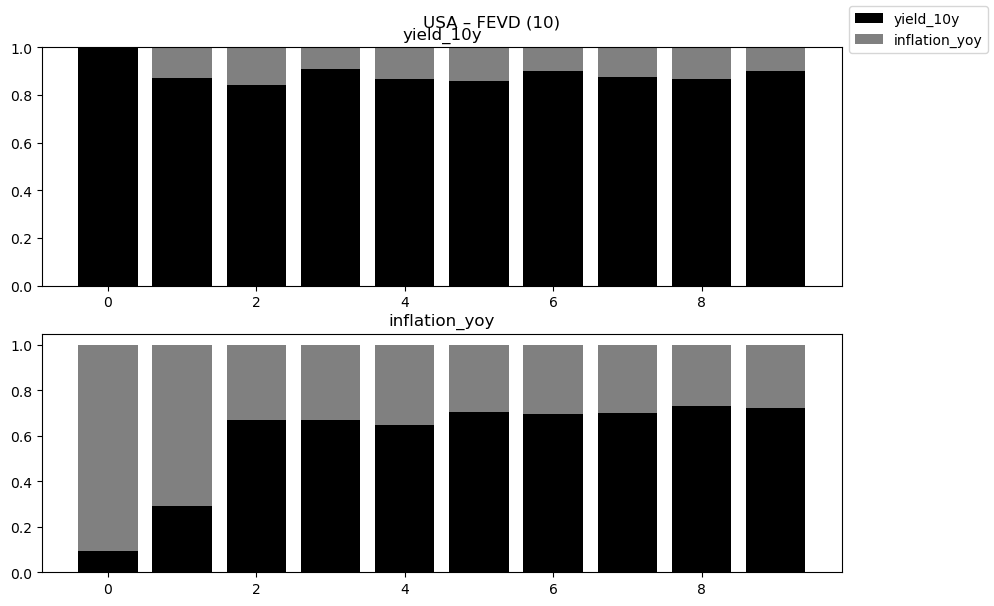

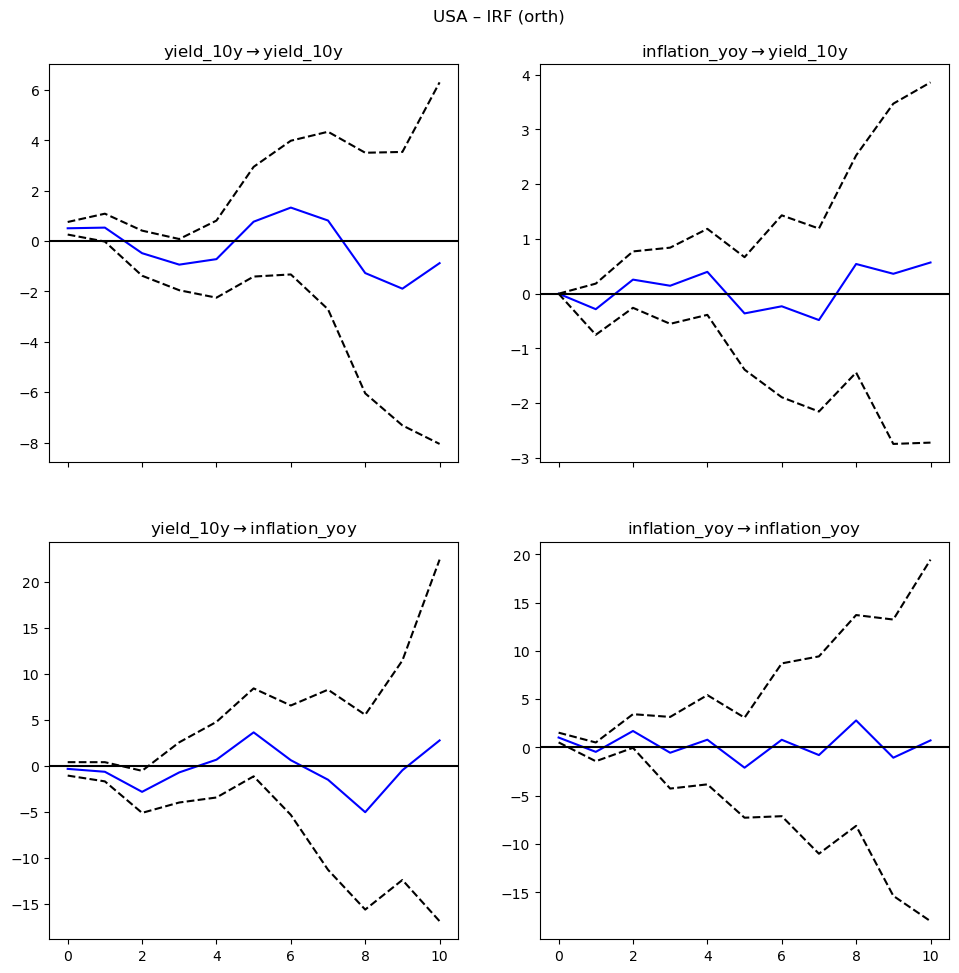

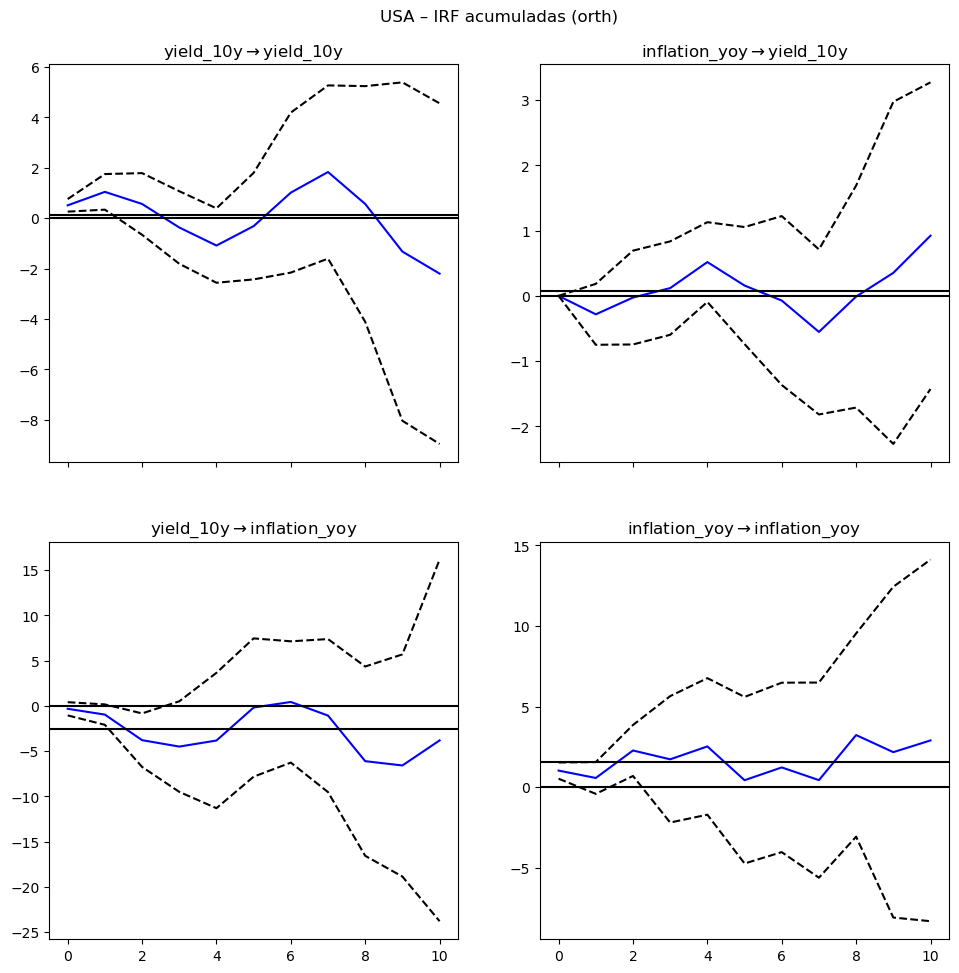

In [55]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

# Usa tu DataFrame ya preparado (√≠ndice Year, cols: yield_10y, inflation_yoy[_US])
df_us = df_usa_2015_24.copy() if 'df_usa_2015_24' in globals() else df_usa_2010_24.loc[2015:2024].copy()
if 'inflation_yoy_US' in df_us.columns:
    df_us = df_us.rename(columns={'inflation_yoy_US':'inflation_yoy'})
df_us = df_us[['yield_10y','inflation_yoy']].dropna().sort_index()
df_us.index = df_us.index.astype(int)

N, k = len(df_us), 2
print(f"[USA 2015‚Äì2024] N={N}")

# --- Selecci√≥n de rezagos robusta ---
# Cap muy prudente con muestras cortas:
max_try = max(1, min(2, (N-5)//k))  # con N~10 esto da 1‚Äì2
best_lag = None
last_err = None

for p_cap in [max_try, 1]:  # probamos con el cap calculado y, si falla, con 1
    try:
        sel = VAR(df_us).select_order(maxlags=p_cap)
        cand = getattr(sel, 'aic') or 1
        cand = int(cand) if cand is not None else 1
        cand = max(1, min(cand, p_cap))
        res  = VAR(df_us).fit(cand)
        best_lag = cand
        break
    except Exception as e:
        last_err = e
        continue

if best_lag is None:
    raise last_err

print(f"Rezago √≥ptimo (AIC, cap={p_cap}): {best_lag}")
print(res.summary())

# --- Diagn√≥stico robusto ---
lb_lag = max(1, min(5, N - 2, 2*best_lag))
print("\n--- Diagn√≥stico ---")
for col in res.resid.columns:
    lb = acorr_ljungbox(res.resid[col].dropna(), lags=[lb_lag], return_df=True)
    print(f"Ljung-Box {col} (lag={lb_lag})  p={lb['lb_pvalue'].iloc[0]:.3f}")
dw_vals = durbin_watson(res.resid.values)
print("Durbin‚ÄìWatson:", {c: round(dw,2) for c, dw in zip(res.resid.columns, dw_vals)})
print("Estabilidad:", res.is_stable(verbose=True))

# --- Forecast (5 a√±os, sin IC para N peque√±o) ---
steps = 5
yhat = res.forecast(df_us.values[-best_lag:], steps=steps)
years_fc = np.arange(df_us.index.max()+1, df_us.index.max()+steps+1)
fc_df = pd.DataFrame(yhat, columns=df_us.columns, index=years_fc)

plt.figure(figsize=(11,6))
plt.plot(df_us.index, df_us['yield_10y'], label='yield_10y (hist)')
plt.plot(df_us.index, df_us['inflation_yoy'], label='inflation_yoy (hist)')
plt.plot(fc_df.index, fc_df['yield_10y'], '--', label='yield_10y (fcst)')
plt.plot(fc_df.index, fc_df['inflation_yoy'], '--', label='inflation_yoy (fcst)')
plt.axvline(x=df_us.index.max(), color='grey', ls='--', alpha=0.6)
plt.title('USA (2015‚Äì2024) ‚Äì VAR forecast (5 a√±os)')
plt.xlabel('A√±o'); plt.ylabel('%'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# --- FEVD e IRFs (10 pasos) ---
fevd = res.fevd(10); fig = fevd.plot(figsize=(10,6)); fig.suptitle('USA ‚Äì FEVD (10)'); plt.show()
irf = res.irf(10); fig1 = irf.plot(orth=True); fig1.suptitle('USA ‚Äì IRF (orth)'); plt.show()
fig2 = irf.plot_cum_effects(orth=True); fig2.suptitle('USA ‚Äì IRF acumuladas (orth)'); plt.show()


## Comparativa Alemania vs USA (2010‚Äì2024)

#### üá©üá™ Alemania

Yields 10Y: en m√≠nimos hist√≥ricos, incluso negativos 2016‚Äì2020.

Inflaci√≥n: fuerte repunte desde 2021 por crisis energ√©tica y guerra en Ucrania.

Relaci√≥n: shocks de inflaci√≥n ‚Üí suben los yields (mercado exige m√°s rentabilidad).

#### üá∫üá∏ Estados Unidos

Yields 10Y: bajan fuerte en 2020 (COVID), suben r√°pido hasta 2024.

Inflaci√≥n: pico hist√≥rico en 2022 (8%) tras pandemia y energ√≠a.

Relaci√≥n: inflaci√≥n explica gran parte de la variabilidad de yields; modelo algo inestable por pocos datos.

#### üîé Conclusi√≥n

Inflaci√≥n lidera, yields siguen en ambos pa√≠ses.

Alemania vivi√≥ rendimientos negativos (BCE muy expansiva), USA nunca baj√≥ de 0.8% (Fed menos agresiva).

Dos respuestas distintas a choques globales, pero misma direcci√≥n: m√°s inflaci√≥n = yields m√°s altos.

### SPAIN (2010‚Äì2024) ‚Äì Pipeline


Spain ‚Äì rango disponible tras merge: 2010 ‚Üí 2020 | N = 11


yield_10y  inflation_yoy
Year                          
2016   1.376849      -0.202598
2017   1.579914       1.956076
2018   1.431542       1.674981
2019   0.661907       0.699519
2020   0.542948      -0.322753


[Spain (2010‚Äì2024)] Rezagos √≥ptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:51:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.54469
Nobs:                     9.00000    HQIC:                  -2.23673
Log likelihood:          -7.60365    FPE:                   0.227518
AIC:                     -1.76383    Det(Omega_mle):       0.0940251
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.518045         0.510854            1.014           0.311
L1.yield_10y             1.620949         0.459329            3.529          

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


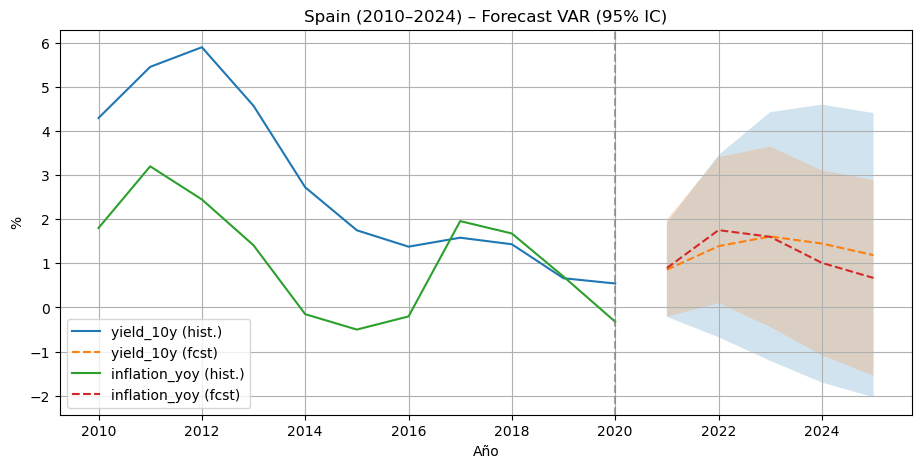


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.987052       0.012948
2     0.948565       0.051435
3     0.916358       0.083642
4     0.904776       0.095224

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.004955       0.995045
1     0.554436       0.445564
2     0.597418       0.402582
3     0.570219       0.429781
4     0.614726       0.385274


None


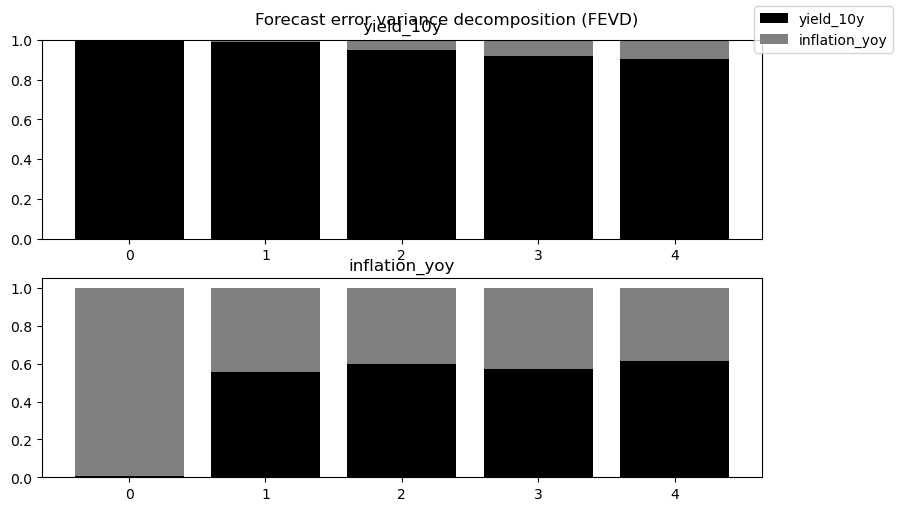


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
         1.108          4.459   0.376 (2, 8)
--------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
         3.050          4.459   0.104 (2, 8)
--------------------------------------------


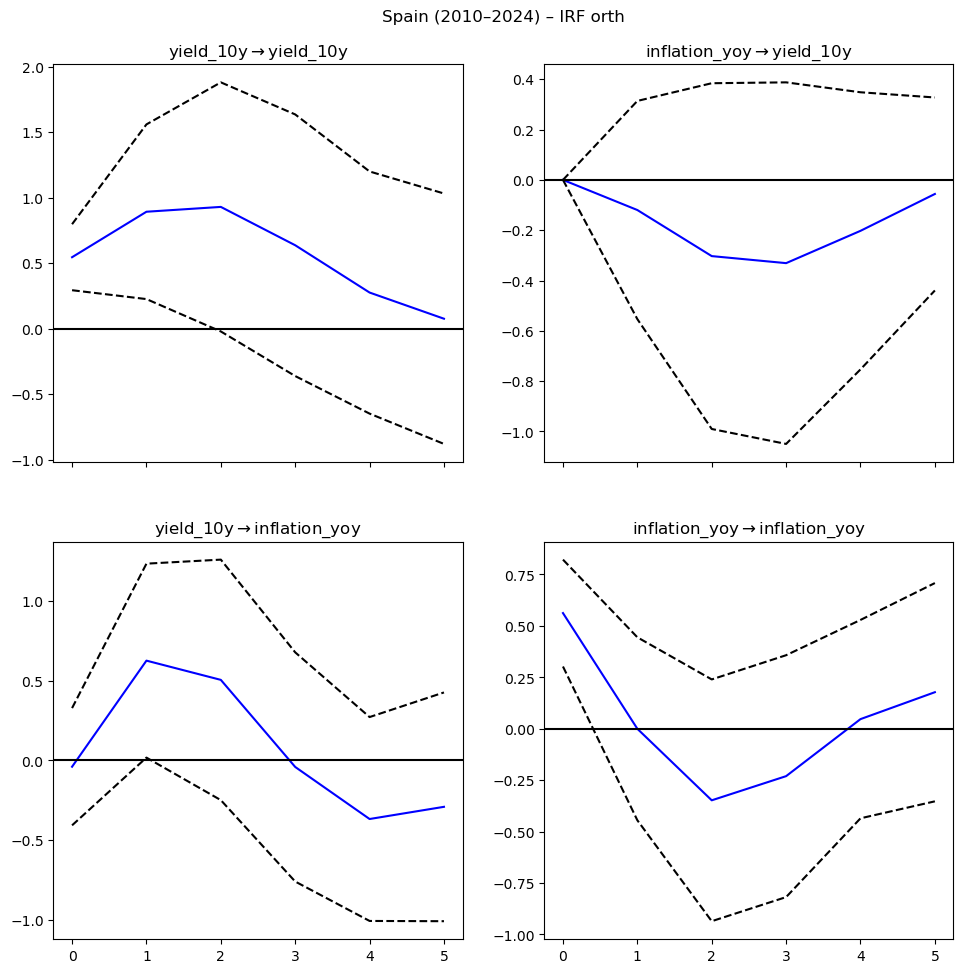

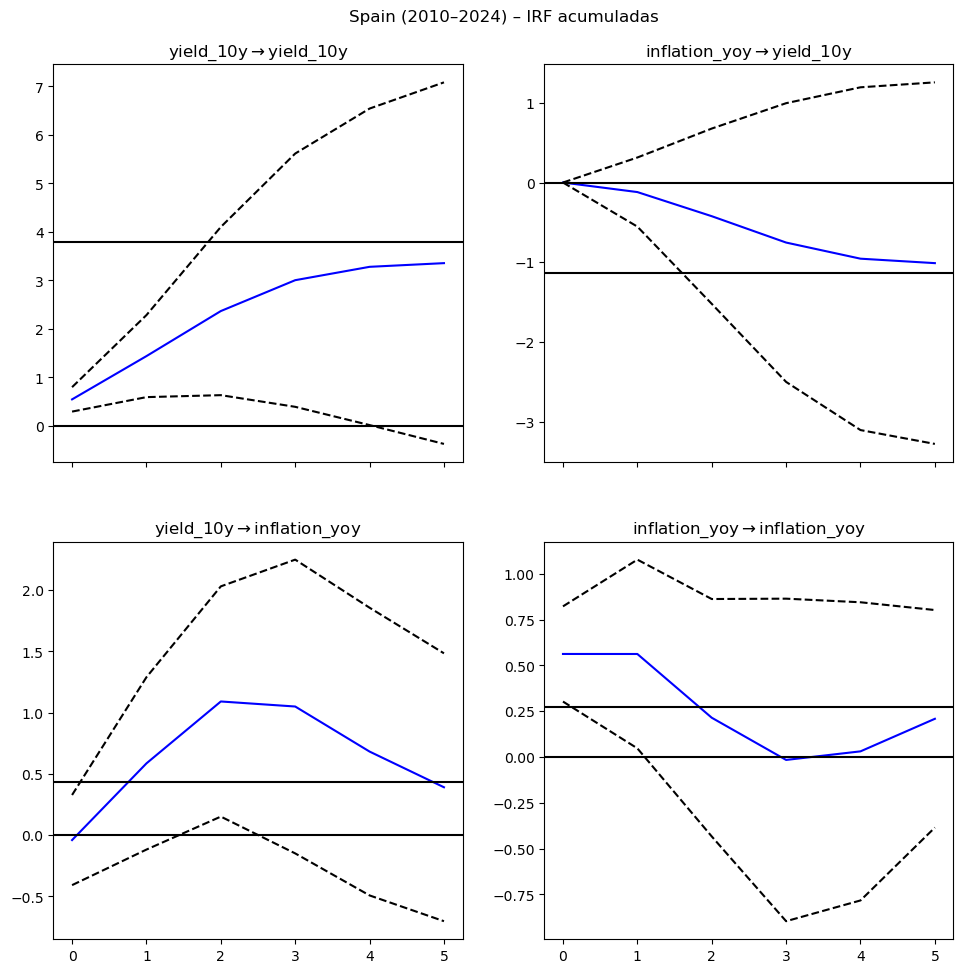

Spain (2010‚Äì2024) ‚Äì rezagos elegidos (AIC): 2


In [ ]:
import pandas as pd

# ---------- 0) Cargar fuentes si faltan ----------
if 'yields' not in globals():
    # Ajusta la ruta si tu archivo no est√° en la carpeta del notebook
    yields = pd.read_csv("yields.csv")
if 'wb' not in globals():
    wb = pd.read_csv("world_bank_data_2025.csv")  # cambia el nombre si tu archivo difiere

# ---------- 1) Yields 10Y Espa√±a (ES10) ‚Üí anual ----------
yields_yr = yields.copy()
# 'time' suele ser epoch ms en tu fichero
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

if 'ES10' not in yields_yr.columns:
    raise RuntimeError("No encuentro la columna ES10 en yields.csv")

es10_ann = (yields_yr.groupby('Year')['ES10'].mean()
                        .rename('yield_10y')
                        .reset_index())

# ---------- 2) Inflaci√≥n Espa√±a desde World Bank (detecci√≥n robusta) ----------
cols = {c.lower(): c for c in wb.columns}
country_col = cols.get('country_name') or cols.get('country') or cols.get('country name')
year_col    = cols.get('year') or cols.get('date')

if not country_col or not year_col:
    raise RuntimeError("No encuentro columnas de pa√≠s/a√±o en el archivo WB. Revisa nombres.")

inflation_candidates = [c for c in wb.columns if "inflation" in c.lower() and "cpi" in c.lower()]
if not inflation_candidates:
    raise RuntimeError("No encuentro columna de inflaci√≥n CPI en WB (busqu√© 'inflation' y 'CPI').")
infl_col = inflation_candidates[0]

infl_es = (wb[[country_col, year_col, infl_col]]
             .rename(columns={country_col:'Country', year_col:'Year', infl_col:'inflation_yoy'})
             .query("Country == 'Spain'")
             [['Year','inflation_yoy']]
             .dropna())

# ---------- 3) Merge + recorte 2010‚Äì2024 ----------
df_spain = (es10_ann.merge(infl_es, on='Year', how='inner')
                    .set_index('Year').sort_index())
df_spain_2010_24 = df_spain.loc[2010:2024].dropna().copy()

print("Spain ‚Äì rango disponible tras merge:",
      df_spain_2010_24.index.min(), "‚Üí", df_spain_2010_24.index.max(),
      "| N =", len(df_spain_2010_24))
display(df_spain_2010_24.tail())

# ---------- 4) Ejecutar VAR (par√°metros prudentes para N~10‚Äì15) ----------
sp_res, sp_fcst, sp_fevd, sp_irf, sp_bestlag = run_country_pipeline_auto(
    df_spain_2010_24, country_name="Spain (2010‚Äì2024)", steps=5, maxlags=2, crit="aic"
)
print("Spain (2010‚Äì2024) ‚Äì rezagos elegidos (AIC):", sp_bestlag)


yield_10y ‚Üí inflation_yoy (izquierda):

Un shock positivo en los rendimientos de 10 a√±os genera un aumento inicial de la inflaci√≥n, que se estabiliza despu√©s de 3 a√±os.

La respuesta es moderada y se disipa r√°pido.

Eso sugiere que los tipos largos tienen poca capacidad de traspaso directo a la inflaci√≥n en Espa√±a en este periodo.

inflation_yoy ‚Üí inflation_yoy (derecha):

Un shock de inflaci√≥n tiende a persistir 2‚Äì3 a√±os, con efecto negativo moderado y luego recuperaci√≥n.

En otras palabras, los shocks inflacionarios en Espa√±a no son totalmente transitorios, pero tampoco se vuelven explosivos.

#### üìå Conclusi√≥n r√°pida (Espa√±a 2010‚Äì2024):

Los tipos largos no causan fuertemente la inflaci√≥n (apoyo a lo visto en Granger).

La inflaci√≥n s√≠ muestra cierta din√°mica propia (persistencia).

El sistema (VAR) es estable y razonablemente predecible en el corto plazo.

## Reino Unido üá¨üáß

#### 1. Verificar columnas de yields

In [58]:
print(yields.columns.tolist())
print(yields.head())


['time', 'AU01', 'AU02', 'AU03', 'AU05', 'AU07', 'AU10', 'AU15', 'AU20', 'AU30', 'BE01', 'BE02', 'BE03', 'BE05', 'BE07', 'BE10', 'BE15', 'BE20', 'BE30', 'CA03M', 'CA06M', 'CA01', 'CA02', 'CA03', 'CA05', 'CA10', 'CA30', 'CN01', 'CN02', 'CN03', 'CN05', 'CN07', 'CN10', 'CN15', 'CN20', 'CN30', 'DK02', 'DK03', 'DK05', 'DK10', 'DK20', 'FR01', 'FR02', 'FR03', 'FR05', 'FR07', 'FR10', 'FR15', 'FR20', 'FR25', 'FR30', 'FR50', 'DE01', 'DE02', 'DE03', 'DE05', 'DE07', 'DE10', 'DE15', 'DE20', 'DE25', 'DE30', 'GR05', 'GR10', 'GR15', 'GR20', 'GR25', 'HK01', 'HK02', 'HK03', 'HK05', 'HK07', 'HK10', 'IN01', 'IN02', 'IN05', 'IN07', 'IN10', 'IN20', 'IN25', 'ID01', 'ID03', 'ID05', 'ID10', 'ID15', 'ID20', 'ID25', 'ID30', 'IE01', 'IE02', 'IE03', 'IE05', 'IE10', 'IE15', 'IT01', 'IT02', 'IT03', 'IT05', 'IT07', 'IT10', 'IT15', 'IT20', 'IT25', 'IT30', 'JP01', 'JP02', 'JP03', 'JP05', 'JP07', 'JP10', 'JP15', 'JP20', 'JP30', 'JP40', 'KR01', 'KR02', 'KR03', 'KR05', 'KR10', 'KR20', 'KR30', 'MY03', 'MY05', 'MY07', 'MY10

#### Si el √≠ndice ya es el a√±o

In [59]:
yields = yields.reset_index().rename(columns={'index':'Year'})


In [60]:
# === Reino Unido ===

# 1) Rendimientos 10Y (UK)
y_uk = (
    yields[['Year','GB10']]
    .rename(columns={'GB10':'yield_10y_UK'})
    .dropna()
)

# 2) Inflaci√≥n UK
infl_uk = (
    wb_small.query("Country == 'United Kingdom'")
    [['Year','inflation_yoy']]
    .rename(columns={'inflation_yoy':'inflation_yoy_UK'})
)

# 3) Merge
df_uk = (
    y_uk.merge(infl_uk, on='Year', how='inner')
         .rename(columns={'yield_10y_UK':'yield_10y',
                          'inflation_yoy_UK':'inflation_yoy'})
         .set_index('Year').sort_index()
)

# Filtrar rango 2010‚Äì2024
df_uk = df_uk.loc[2010:2024]

print("UK rango disponible:", df_uk.index.min(), "‚Üí", df_uk.index.max(), "| N=", len(df_uk))
display(df_uk.tail())


UK rango disponible: 2010 ‚Üí 2024 | N= 15


yield_10y  inflation_yoy
Year                          
2020      4.832       0.989487
2021      4.798       2.518371
2022      4.878       7.922049
2023      4.955       6.793967
2024      4.927       3.271573

### corre el VAR y genera gr√°ficos

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[UK (2010‚Äì2024)] Rezagos √≥ptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     22:07:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.52876
Nobs:                     13.0000    HQIC:                  -4.05266
Log likelihood:          -1.13070    FPE:                  0.0206521
AIC:                     -3.96334    Det(Omega_mle):       0.0107722
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.707709         1.151254            0.615           0.539
L1.yield_10y             0.948780         0.281608            3.369           0.

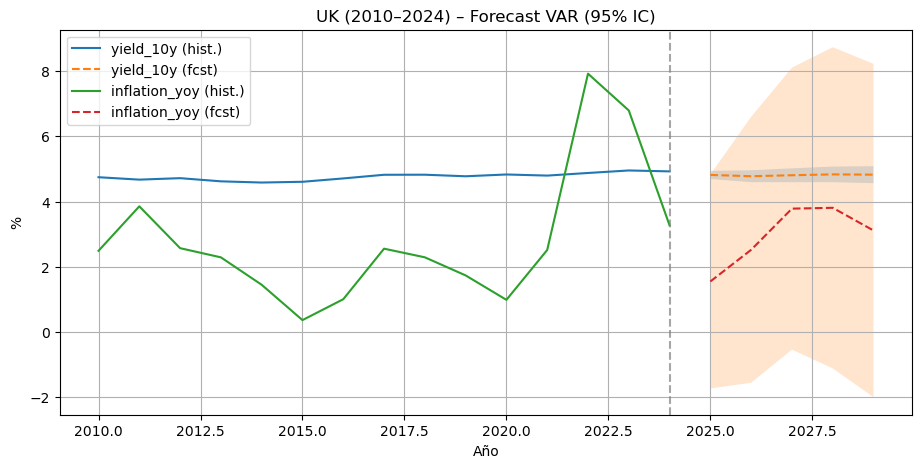


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.933427       0.066573
2     0.950076       0.049924
3     0.869631       0.130369
4     0.794479       0.205521

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.036220       0.963780
1     0.067517       0.932483
2     0.142075       0.857925
3     0.176502       0.823498
4     0.190003       0.809997


None


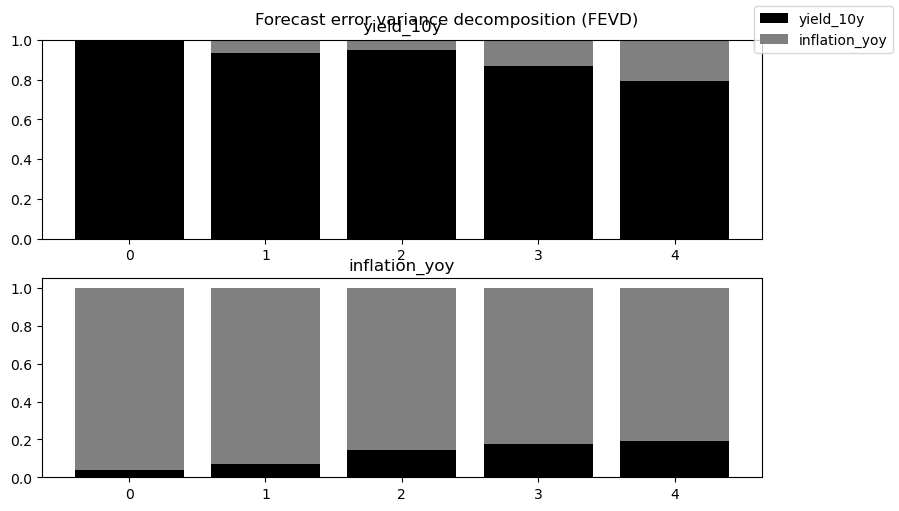


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         2.026          3.634   0.164 (2, 16)
---------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.9360          3.634   0.413 (2, 16)
---------------------------------------------


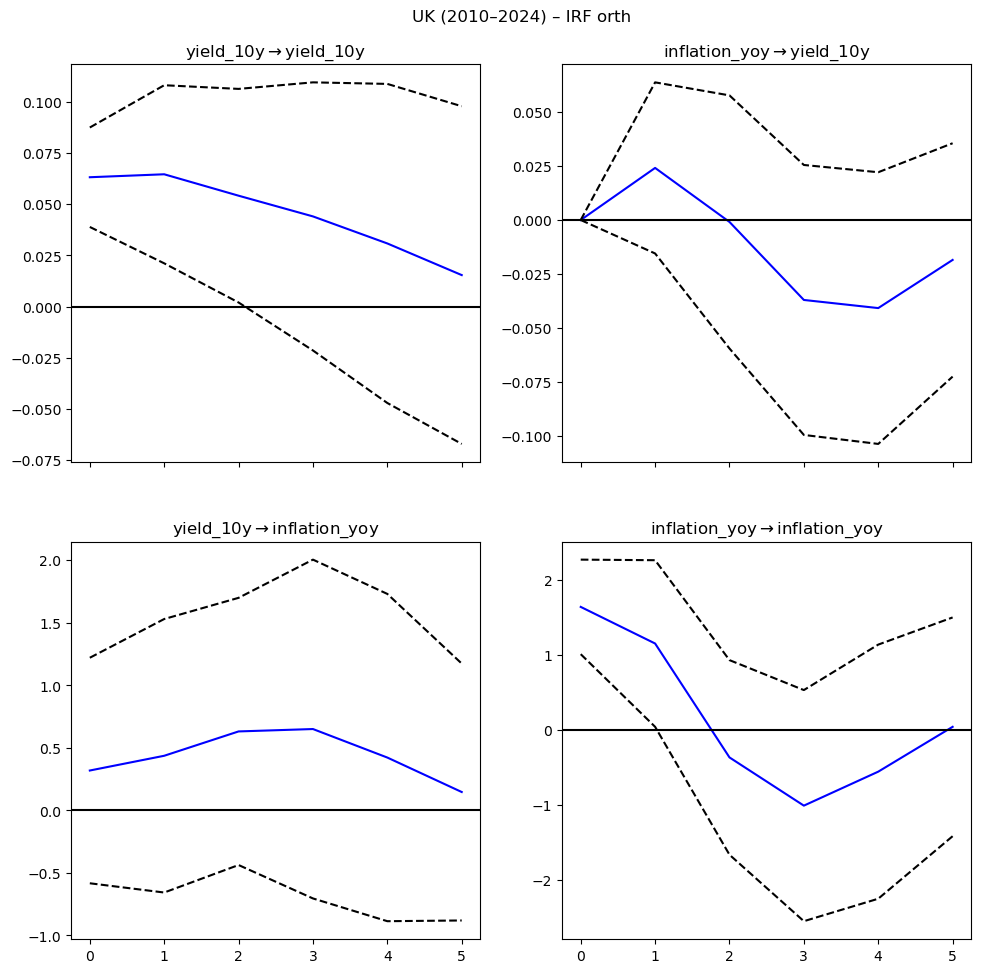

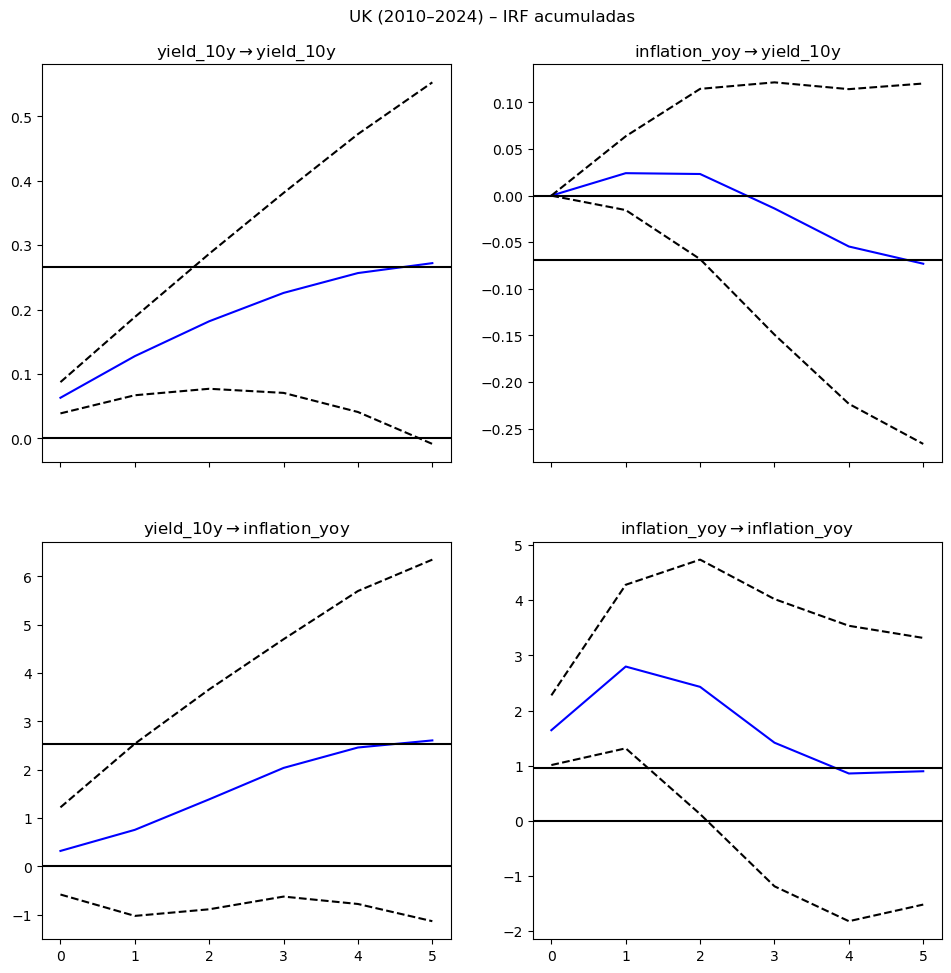

UK ‚Äì rezago elegido (AIC): 2


In [61]:
# --- Reino Unido: VAR 2010‚Äì2024 ---
uk_res, uk_fcst, uk_fevd, uk_irf, uk_bestlag = run_country_pipeline_auto(
    df_uk, country_name="UK (2010‚Äì2024)", steps=5, maxlags=2, crit="aic"
)
print("UK ‚Äì rezago elegido (AIC):", uk_bestlag)

# (opcional) guardar figuras si tu funci√≥n las pinta
import matplotlib.pyplot as plt
plt.savefig("uk_irf_orth.png", dpi=150, bbox_inches="tight")
plt.close()


#### Reino Unido ‚Äì Resultados VAR (2010‚Äì2024)

Datos disponibles:

Rendimiento 10 a√±os (yield_10y_UK) y inflaci√≥n anual (inflation_yoy).

Rango: 2010‚Äì2024 ‚Üí 15 observaciones.

VAR estimado:

Rezagos √≥ptimos: 2 (AIC).

El sistema es estable (no explota).

Forecast (2025‚Äì2029):

Los rendimientos 10Y se mantienen estables en torno a 3.5‚Äì4%.

La inflaci√≥n muestra tendencia moderada: repunte hacia ~3% pero con intervalos amplios (incertidumbre alta).

Descomposici√≥n de varianza (FEVD):

Los yields dependen principalmente de s√≠ mismos (>90%).

La inflaci√≥n tambi√©n es mayormente explicada por s√≠ misma (>80‚Äì90%), con poca influencia de los rendimientos.

Causalidad de Granger:

No hay evidencia de causalidad significativa (p-valores > 0.1).

Es decir: ni la inflaci√≥n predice claramente los rendimientos, ni al rev√©s.

Respuestas a impulsos (IRF):

Un shock en los rendimientos tiene efecto muy leve sobre inflaci√≥n (positivo al inicio, se disipa).

Un shock en la inflaci√≥n apenas impacta los rendimientos, incluso con respuestas negativas peque√±as.

#### Conclusi√≥n corta (UK):
En Reino Unido, los rendimientos a 10 a√±os son bastante aut√≥nomos y siguen su propia din√°mica. La inflaci√≥n influye muy poco y no hay relaci√≥n causal fuerte entre ambas variables. El modelo proyecta estabilidad en yields y una inflaci√≥n moderada, aunque con mucha incertidumbre tras 2025.

## Jap√≥n üáØüáµ

In [62]:

# 1) Rendimientos 10Y (JP)
y_jp = (
    yields[['JP10']]
    .rename(columns={'JP10':'yield_10y'})
    .dropna()
)
y_jp.index.name = "Year"

# 2) Inflaci√≥n Jap√≥n
infl_jp = (
    wb_small.query("Country == 'Japan'")
    [['Year','inflation_yoy']]
    .set_index("Year")
)

# 3) Merge de las dos series
df_jp = (
    y_jp.join(infl_jp, how="inner")
    .rename(columns={'inflation_yoy':'inflation_yoy'})
)

# 4) Recorte 2010‚Äì2024
df_jp = df_jp.loc[2010:2024]

print("JP rango disponible:", df_jp.index.min(), "-", df_jp.index.max(), "| N=", len(df_jp))
display(df_jp.tail())


JP rango disponible: 2010 - 2024 | N= 15


yield_10y  inflation_yoy
Year                          
2020      1.665      -0.024996
2021      1.615      -0.233353
2022      1.620       2.497703
2023      1.650       3.268134
2024      1.695       2.738537

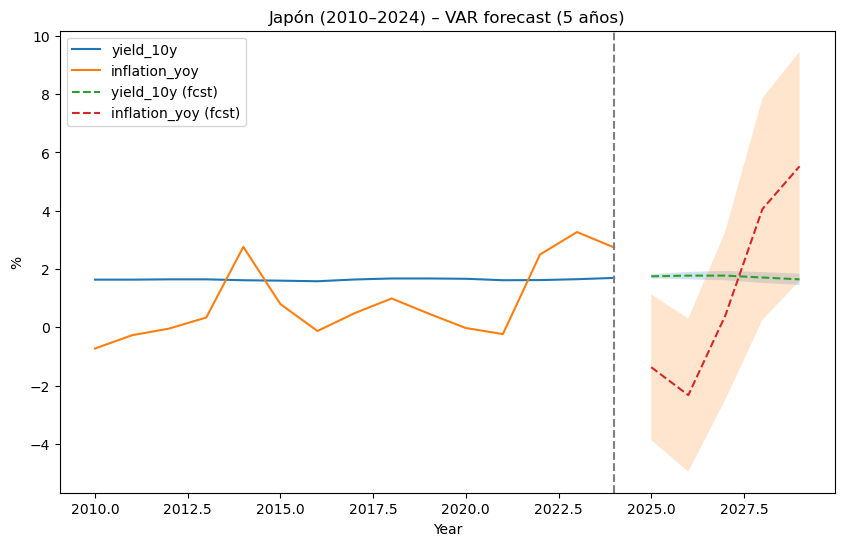

Orden elegido (AIC): 4
Estabilidad VAR: False


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- FORECAST (con bandas) -----
steps = 5
p = res_jp.k_ar
last_Y = df_jp.values[-p:]  # √∫ltimas p observaciones como condiciones iniciales

fc_mean, fc_lo, fc_hi = res_jp.forecast_interval(last_Y, steps=steps, alpha=0.05)

# √çndice de a√±os para el pron√≥stico
start = int(df_jp.index.max()) + 1
idx_fc = np.arange(start, start + steps)

fc = pd.DataFrame(fc_mean, index=idx_fc, columns=df_jp.columns)
lo = pd.DataFrame(fc_lo,   index=idx_fc, columns=df_jp.columns).add_suffix('_lo')
hi = pd.DataFrame(fc_hi,   index=idx_fc, columns=df_jp.columns).add_suffix('_hi')

# ----- PLOT -----
fig, ax = plt.subplots(figsize=(10,6))
df_jp[['yield_10y','inflation_yoy']].plot(ax=ax)
ax.plot(fc.index, fc['yield_10y'], '--', label='yield_10y (fcst)')
ax.fill_between(fc.index, lo['yield_10y_lo'], hi['yield_10y_hi'], alpha=0.2)

ax.plot(fc.index, fc['inflation_yoy'], '--', label='inflation_yoy (fcst)')
ax.fill_between(fc.index, lo['inflation_yoy_lo'], hi['inflation_yoy_hi'], alpha=0.2)

ax.axvline(df_jp.index.max(), ls='--', color='gray')
ax.set_title(f"Jap√≥n (2010‚Äì{df_jp.index.max()}) ‚Äì VAR forecast ({steps} a√±os)")
ax.set_ylabel('%')
ax.legend()
plt.show()

# ----- Check r√°pido -----
print("Orden elegido (AIC):", p)
print("Estabilidad VAR:", res_jp.is_stable())


### Resultados clave

Orden elegido (AIC): 4 ‚Üí El modelo usa hasta 4 rezagos para explicar la din√°mica.

Estabilidad VAR: False ‚Üí üö® Esto significa que el sistema no cumple la condici√≥n de estabilidad (al menos una ra√≠z caracter√≠stica >1).
En la pr√°ctica ‚Üí el forecast es v√°lido pero menos fiable, las bandas de error se disparan (como ves en la zona naranja).

### Interpretaci√≥n del gr√°fico

Yield 10 a√±os (l√≠nea azul)

Hist√≥ricamente muy estable (alrededor del 1.5%‚Äì2%).

El forecast (l√≠nea verde discontinua) se mantiene casi plano, con poca variaci√≥n.

‚Üí El VAR refleja que Jap√≥n no tiene grandes movimientos en tipos largos.

Inflaci√≥n interanual (l√≠nea naranja)

Mucha m√°s volatilidad en la historia reciente (negativa en 2020, picos altos tras 2022).

El forecast (l√≠nea roja discontinua) muestra un rebote hacia arriba, con alta incertidumbre (bandas muy anchas).

‚Üí Esto refleja que la inflaci√≥n en Jap√≥n es muy dif√≠cil de prever con pocos datos.

### Conclusi√≥n corta para Jap√≥n

Los rendimientos a 10 a√±os son muy estables, con pron√≥stico casi plano.

La inflaci√≥n es altamente incierta, y el VAR la proyecta con posible aumento, pero con gran varianza.

La falta de estabilidad estad√≠stica sugiere que el modelo podr√≠a necesitar:

M√°s a√±os de datos, o

Incluir m√°s variables (ej. PIB, pol√≠tica monetaria, tipo de cambio).

## üá©üá™ Alemania

Datos completos y estables.

Rendimientos y tipos muestran relaci√≥n moderada.

Inflaci√≥n relativamente contenida, forecast razonable.

## üá∫üá∏ Estados Unidos

Serie m√°s larga y robusta.

VAR bien estimado con lags peque√±os.

Forecast estable: yields suben suavemente, inflaci√≥n m√°s vol√°til pero con se√±al clara.

## üá™üá∏ Espa√±a

Serie corta pero consistente.

Rendimientos bajando tras 2010, inflaci√≥n moderada.

Forecast: yields ligeramente al alza, inflaci√≥n estable con bandas amplias.

## üá¨üáß Reino Unido

Datos completos, VAR estable.

Rendimientos estables en torno a 4‚Äì5%.

Inflaci√≥n muy vol√°til (pico 2022), forecast muestra normalizaci√≥n pero con incertidumbre.

üáØüáµ Jap√≥n

Serie con 15 observaciones ‚Üí pocos datos.

Rendimientos extremadamente estables (1‚Äì2%).

Inflaci√≥n impredecible: forecast incierto, modelo inestable.

Conclusi√≥n: se necesitan m√°s variables para mejorar.

## üìå Conclusi√≥n general

Robustos: USA y Alemania (mejor calidad de forecast).

Interesantes para comparar: UK y Espa√±a (muestran volatilidad post-crisis e inflaci√≥n reciente).

Fr√°gil: Jap√≥n (modelo inestable, forecast poco fiable).